<a href="https://colab.research.google.com/github/escuccim/vaegan-pytorch/blob/master/VAEGAN_Densenet201_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt, colors
%matplotlib inline
import zipfile
import os
import matplotlib.animation as animation
import torchvision.utils as vutils
import numpy as np
import re
import random
import pandas as pd
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset
from torch import Tensor
from torch.optim import RMSprop,Adam,SGD
from torch.optim.lr_scheduler import ExponentialLR,MultiStepLR
import progressbar
from torchvision.utils import make_grid
from torch.autograd import Variable
from torch.utils.data import Dataset
from torch.optim import RMSprop,Adam,SGD
from torch.optim.lr_scheduler import ExponentialLR,MultiStepLR
from torchvision.utils import make_grid
from sklearn.metrics import f1_score
import torchvision.utils as vutils
from collections import OrderedDict
from torch.hub import load_state_dict_from_url

from google.colab import auth
auth.authenticate_user()

# upload checkpoint to GCS
project_id = 'mammography-198911'
bucket_name = 'gan-faces'

!gcloud config set project {project_id}

Updated property [core/project].


In [2]:
!nvidia-smi

Sat Nov  9 07:50:05 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.50       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P0    33W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
model_save_path = "vaegan_dn201_2.pt"
disc_opt_save_path = "vaegan_dn201_opt_disc_2.pt"
enc_opt_save_path = "vaegan_dn201_opt_enc_2.pt"
dec_opt_save_path = "vaegan_dn201_opt_dec_2.pt"

In [4]:
if not os.path.exists(model_save_path):
  !gsutil cp gs://{bucket_name}/{model_save_path} ./{model_save_path} 
  !gsutil cp gs://{bucket_name}/{disc_opt_save_path} ./{disc_opt_save_path} 
  !gsutil cp gs://{bucket_name}/{dec_opt_save_path} ./{dec_opt_save_path} 
  !gsutil cp gs://{bucket_name}/{enc_opt_save_path} ./{enc_opt_save_path} 

Copying gs://gan-faces/vaegan_dn201_2.pt...
- [1 files][195.7 MiB/195.7 MiB]                                                
Operation completed over 1 objects/195.7 MiB.                                    
Copying gs://gan-faces/vaegan_dn201_opt_disc_2.pt...
/ [1 files][ 69.4 MiB/ 69.4 MiB]                                                
Operation completed over 1 objects/69.4 MiB.                                     
Copying gs://gan-faces/vaegan_dn201_opt_dec_2.pt...
| [1 files][ 47.6 MiB/ 47.6 MiB]                                                
Operation completed over 1 objects/47.6 MiB.                                     
Copying gs://gan-faces/vaegan_dn201_opt_enc_2.pt...
/ [1 files][ 76.6 MiB/ 76.6 MiB]                                                
Operation completed over 1 objects/76.6 MiB.                                     


In [5]:
if not os.path.exists("celeba-dataset.zip"):
#   !kaggle datasets download -d jessicali9530/celeba-dataset
  !gsutil cp gs://{bucket_name}/celeba-dataset.zip ./celeba-dataset.zip
  zip_ref = zipfile.ZipFile('celeba-dataset.zip', 'r')
  zip_ref.extractall('data')
  zip_ref.close()

  zip_ref = zipfile.ZipFile('data/img_align_celeba.zip', 'r')
  zip_ref.extractall('data/celeba')
  zip_ref.close()

# if not os.path.exists("wiki_images_good.zip"):
#   !gsutil cp gs://{bucket_name}/wiki_images_good.zip ./ 
#   zip_ref = zipfile.ZipFile('wiki_images_good.zip', 'r')
#   zip_ref.extractall('data/wiki_images')
#   zip_ref.close()  

if not os.path.exists("celeb_a_good.zip"):
#   !kaggle datasets download -d jessicali9530/celeba-dataset
  !gsutil cp gs://pneumonia/celeb_a_good.zip ./celeb_a_good.zip
  zip_ref = zipfile.ZipFile('celeb_a_good.zip', 'r')
  zip_ref.extractall('data/images/celeb_a')
  zip_ref.close()

# if not os.path.exists("Training_Pictures.zip"):
#   !wget https://s3.eu-west-3.amazonaws.com/deep.skoo.ch/Training_Pictures.zip
#   zip_ref = zipfile.ZipFile('Training_Pictures.zip', 'r')
#   zip_ref.extractall('data/images/training')
#   zip_ref.close()

# if not os.path.exists("crop_part1_good.zip"):
#   !gsutil cp gs://{bucket_name}/crop_part1_good.zip ./crop_part1_good.zip
#   zip_ref = zipfile.ZipFile('crop_part1_good.zip', 'r')
#   zip_ref.extractall('data/images/crop_parta')
#   zip_ref.close()   

Copying gs://gan-faces/celeba-dataset.zip...
| [1 files][  1.2 GiB/  1.2 GiB]   50.7 MiB/s                                   
Operation completed over 1 objects/1.2 GiB.                                      
Copying gs://pneumonia/celeb_a_good.zip...
\ [1 files][  1.1 GiB/  1.1 GiB]   33.4 MiB/s                                   
Operation completed over 1 objects/1.1 GiB.                                      


In [6]:
if not os.path.exists("wiki_images_good.zip"):
  !gsutil cp gs://{bucket_name}/wiki_images_good.zip ./wiki_images_good.zip
  zip_ref = zipfile.ZipFile('wiki_images_good.zip', 'r')
  zip_ref.extractall('data/test_images')
  zip_ref.close()  

Copying gs://gan-faces/wiki_images_good.zip...
/ [1 files][ 94.7 MiB/ 94.7 MiB]                                                
Operation completed over 1 objects/94.7 MiB.                                     


In [0]:
model_urls = {
    'densenet121': 'https://download.pytorch.org/models/densenet121-a639ec97.pth',
    'densenet169': 'https://download.pytorch.org/models/densenet169-b2777c0a.pth',
    'densenet201': 'https://download.pytorch.org/models/densenet201-c1103571.pth',
    'densenet161': 'https://download.pytorch.org/models/densenet161-8d451a50.pth',
}

In [0]:
def masked_f1_score(outputs, labels):
    # mins, _ = labels.min(dim=1)
    mask = labels != -1
    f1 = f1_score(torch.squeeze(labels[mask].detach().cpu().float().view(-1)), torch.round(outputs[mask].detach().cpu().float().view(-1)), average="micro")
    return f1

class _DenseLayer(nn.Module):
    def __init__(self, num_input_features, growth_rate, bn_size, drop_rate, memory_efficient=False):
        super(_DenseLayer, self).__init__()
        self.add_module('norm1', nn.BatchNorm2d(num_input_features)),
        self.add_module('relu1', nn.LeakyReLU(0.2, inplace=True)),
        self.add_module('conv1', nn.Conv2d(num_input_features, bn_size *
                                           growth_rate, kernel_size=1, stride=1,
                                           bias=False)),
        self.add_module('norm2', nn.BatchNorm2d(bn_size * growth_rate)),
        self.add_module('relu2', nn.LeakyReLU(0.2, inplace=True)),
        self.add_module('conv2', nn.Conv2d(bn_size * growth_rate, growth_rate,
                                           kernel_size=3, stride=1, padding=1,
                                           bias=False)),
        self.drop_rate = float(drop_rate)
        self.memory_efficient = memory_efficient

    def bn_function(self, inputs):
        # type: (List[Tensor]) -> Tensor
        concated_features = torch.cat(inputs, 1)
        bottleneck_output = self.conv1(self.relu1(self.norm1(concated_features)))  # noqa: T484
        return bottleneck_output

    # todo: rewrite when torchscript supports any
    def any_requires_grad(self, input):
        # type: (List[Tensor]) -> bool
        for tensor in input:
            if tensor.requires_grad:
                return True
        return False

    # @torch.jit.unused  # noqa: T484
    def call_checkpoint_bottleneck(self, input):
        # type: (List[Tensor]) -> Tensor
        def closure(*inputs):
            return self.bn_function(*inputs)

        return cp.checkpoint(closure, input)

    # @torch.jit._overload_method  # noqa: F811
    def forward(self, input):
        # type: (List[Tensor]) -> (Tensor)
        pass

    # @torch.jit._overload_method  # noqa: F811
    def forward(self, input):
        # type: (Tensor) -> (Tensor)
        pass

    # torchscript does not yet support *args, so we overload method
    # allowing it to take either a List[Tensor] or single Tensor
    def forward(self, input):  # noqa: F811
        if isinstance(input, Tensor):
            prev_features = [input]
        else:
            prev_features = input

        if self.memory_efficient and self.any_requires_grad(prev_features):
            if torch.jit.is_scripting():
                raise Exception("Memory Efficient not supported in JIT")

            bottleneck_output = self.call_checkpoint_bottleneck(prev_features)
        else:
            bottleneck_output = self.bn_function(prev_features)

        new_features = self.conv2(self.relu2(self.norm2(bottleneck_output)))
        if self.drop_rate > 0:
            new_features = F.dropout(new_features, p=self.drop_rate,
                                     training=self.training)
        return new_features

class _Transition(nn.Sequential):
    def __init__(self, num_input_features, num_output_features):
        super(_Transition, self).__init__()
        self.add_module('norm', nn.BatchNorm2d(num_input_features))
        self.add_module('relu', nn.ReLU(inplace=True))
        self.add_module('conv', nn.Conv2d(num_input_features, num_output_features,
                                          kernel_size=1, stride=1, bias=False))
        self.add_module('pool', nn.AvgPool2d(kernel_size=2, stride=2))

class _DenseBlock(nn.Module):
    _version = 2
    __constants__ = ['layers']

    def __init__(self, num_layers, num_input_features, bn_size, growth_rate, drop_rate, memory_efficient=False):
        super(_DenseBlock, self).__init__()
        self.layers = nn.ModuleDict()
        for i in range(num_layers):
            layer = _DenseLayer(
                num_input_features + i * growth_rate,
                growth_rate=growth_rate,
                bn_size=bn_size,
                drop_rate=drop_rate,
                memory_efficient=memory_efficient,
            )
            self.layers['denselayer%d' % (i + 1)] = layer

    def forward(self, init_features):
        features = [init_features]
        for name, layer in self.layers.items():
            new_features = layer(features)
            features.append(new_features)
        return torch.cat(features, 1)

    @torch.jit.ignore
    def _load_from_state_dict(self, state_dict, prefix, local_metadata, strict,
                              missing_keys, unexpected_keys, error_msgs):
        version = local_metadata.get('version', None)
        if (version is None or version < 2):
            # now we have a new nesting level for torchscript support
            for new_key in self.state_dict().keys():
                # remove prefix "layers."
                old_key = new_key[len("layers."):]
                old_key = prefix + old_key
                new_key = prefix + new_key
                if old_key in state_dict:
                    value = state_dict[old_key]
                    del state_dict[old_key]
                    state_dict[new_key] = value
        super(_DenseBlock, self)._load_from_state_dict(
            state_dict, prefix, local_metadata, strict,
            missing_keys, unexpected_keys, error_msgs)

class DenseNet(torchvision.models.densenet.DenseNet):
    r"""Densenet-BC model class, based on
    `"Densely Connected Convolutional Networks" <https://arxiv.org/pdf/1608.06993.pdf>`_
    Args:
        growth_rate (int) - how many filters to add each layer (`k` in paper)
        block_config (list of 4 ints) - how many layers in each pooling block
        num_init_features (int) - the number of filters to learn in the first convolution layer
        bn_size (int) - multiplicative factor for number of bottle neck layers
          (i.e. bn_size * k features in the bottleneck layer)
        drop_rate (float) - dropout rate after each dense layer
        num_classes (int) - number of classification classes
        memory_efficient (bool) - If True, uses checkpointing. Much more memory efficient,
          but slower. Default: *False*. See `"paper" <https://arxiv.org/pdf/1707.06990.pdf>`_
    """

    __constants__ = ['features']
    
    def __init__(self, growth_rate=32, block_config=(6, 12, 24, 16),
                 num_init_features=64, bn_size=4, drop_rate=0, num_classes=1000, memory_efficient=False):

        super(DenseNet, self).__init__()

        # First convolution
        self.features = nn.Sequential(OrderedDict([
            ('conv0', nn.Conv2d(3, num_init_features, kernel_size=7, stride=2,
                                padding=3, bias=False)),
            ('norm0', nn.BatchNorm2d(num_init_features)),
            ('relu0', nn.LeakyReLU(0.2, inplace=True)),
            ('pool0', nn.AvgPool2d(kernel_size=3, stride=2, padding=1)),
        ]))

        # Each denseblock
        num_features = num_init_features
        for i, num_layers in enumerate(block_config):
            block = _DenseBlock(
                num_layers=num_layers,
                num_input_features=num_features,
                bn_size=bn_size,
                growth_rate=growth_rate,
                drop_rate=drop_rate,
                memory_efficient=memory_efficient
            )
            self.features.add_module('denseblock%d' % (i + 1), block)
            num_features = num_features + num_layers * growth_rate
            if i != len(block_config) - 1:
                trans = _Transition(num_input_features=num_features,
                                    num_output_features=num_features // 2)
                self.features.add_module('transition%d' % (i + 1), trans)
                num_features = num_features // 2

        # Final batch norm
        self.features.add_module('norm5', nn.BatchNorm2d(num_features))

        # Linear layer
        self.classifier = nn.Linear(num_features, num_classes)

        # Official init from torch repo.
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.constant_(m.bias, 0)
                
    def forward(self, x):
        features = self.features(x)
        feature_map = F.relu(features, inplace=False)
        out = F.adaptive_avg_pool2d(feature_map, (1, 1))
        out = torch.flatten(out, 1)
        output = self.classifier(out, feature_map=features)
        return output
    
def _load_state_dict(model, model_url, progress):
    # '.'s are no longer allowed in module names, but previous _DenseLayer
    # has keys 'norm.1', 'relu.1', 'conv.1', 'norm.2', 'relu.2', 'conv.2'.
    # They are also in the checkpoints in model_urls. This pattern is used
    # to find such keys.
    pattern = re.compile(
        r'^(.*denselayer\d+\.(?:norm|relu|conv))\.((?:[12])\.(?:weight|bias|running_mean|running_var))$')

    state_dict = load_state_dict_from_url(model_url, progress=progress)
    for key in list(state_dict.keys()):
        res = pattern.match(key)
        if res:
            new_key = res.group(1) + res.group(2)
            state_dict[new_key] = state_dict[key]
            del state_dict[key]
    model.load_state_dict(state_dict)

def _densenet(arch, growth_rate, block_config, num_init_features, pretrained, progress,
              **kwargs):
    model = DenseNet(growth_rate, block_config, num_init_features, **kwargs)
    if pretrained:
        _load_state_dict(model, model_urls[arch], progress)
    return model        
        
def densenet169(pretrained=False, progress=True, **kwargs):
    r"""Densenet-169 model from
    `"Densely Connected Convolutional Networks" <https://arxiv.org/pdf/1608.06993.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
        memory_efficient (bool) - If True, uses checkpointing. Much more memory efficient,
          but slower. Default: *False*. See `"paper" <https://arxiv.org/pdf/1707.06990.pdf>`_
    """
    return _densenet('densenet169', 32, (6, 12, 32, 32), 64, pretrained, progress,
                     **kwargs)   

def densenet201(pretrained=False, progress=True, **kwargs):
    r"""Densenet-201 model from
    `"Densely Connected Convolutional Networks" <https://arxiv.org/pdf/1608.06993.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
        memory_efficient (bool) - If True, uses checkpointing. Much more memory efficient,
          but slower. Default: *False*. See `"paper" <https://arxiv.org/pdf/1707.06990.pdf>`_
    """
    return _densenet('densenet201', 32, (6, 12, 48, 32), 64, pretrained, progress,
                     **kwargs)

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=4, stride=2, padding=0, bias=False):
        super(DecoderBlock, self).__init__()
        # transpose convolution to double the dimensions
        self.conv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding, stride=stride,
                                       bias=bias)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.LeakyReLU(0.2, inplace=False)

    def forward(self, ten):
        c1 = self.conv(ten)
        bn = self.bn(c1)
        relu = self.relu(bn)
        return relu
    
class Decoder(nn.Module):
    def __init__(self, latent_dim=256, ngf=64, ngpu=1):
        super(Decoder, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( latent_dim, ngf * 12, 5, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 12),
            nn.LeakyReLU(0.2, inplace=False),
            # state size. (ngf*8) x 5 x 5
            nn.ConvTranspose2d(ngf * 12, ngf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.LeakyReLU(0.2, inplace=False),
            # state size. (ngf*4) x 10 x 10
            nn.ConvTranspose2d( ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.LeakyReLU(0.2, inplace=False),
            # state size. (ngf*2) x 20 x 20
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.LeakyReLU(0.2, inplace=False),
            # state size. (ngf) x 40 x 40
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 1),
            nn.LeakyReLU(0.2, inplace=False),
            # state size. (ngf) x 80 x 80
            nn.ConvTranspose2d( ngf * 1, 3, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 160 x 160
        )

    def forward(self, input):
        return self.main(input.view(input.shape[0], -1, 1, 1))
    
class DiscriminatorOutput(nn.Module):
    def __init__(self, num_ftrs):
        super(DiscriminatorOutput, self).__init__()
        # Two FC Layers to output discriminator and aux output
        self.discriminator = nn.Linear(num_ftrs, 1)
        self.aux = nn.Linear(num_ftrs, 40)
        
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, features, feature_map=None):
        output = self.discriminator(features)
        aux_output = self.aux(features)
        
        return self.sigmoid(output), feature_map, self.sigmoid(aux_output)

class EncoderOutput(nn.Module):
    def __init__(self, num_ftrs, latent_dim=256):
        super(EncoderOutput, self).__init__()
        # Two FC Layers to output code and logvar
        self.code = nn.Linear(num_ftrs, latent_dim)
        self.logvar = nn.Linear(num_ftrs, latent_dim)
        
    def forward(self, features, feature_map=None):
        code = self.code(features)
        logvar = self.logvar(features)
        return code, logvar

class VaeGan(nn.Module):
    def __init__(self,z_size=128,recon_level=5):
        super(VaeGan, self).__init__()
        # latent space size
        self.z_size = z_size
        
        self.encoder = densenet201(pretrained=True)
        num_ftrs = self.encoder.classifier.in_features
        self.encoder.classifier = EncoderOutput(num_ftrs=num_ftrs, latent_dim=z_size)   

        self.decoder = Decoder(latent_dim=self.z_size, ngf=48)
        
        self.discriminator = densenet201(pretrained=True)
        num_ftrs = self.discriminator.classifier.in_features
        self.discriminator.classifier = DiscriminatorOutput(num_ftrs=num_ftrs)
        
        # self-defined function to init the parameters
        self.init_parameters()

    def init_parameters(self):
        # just explore the network, find every weight and bias matrix and fill it
        for m in self.modules():
            classname = m.__class__.__name__
            if classname.find('Conv') != -1:
                nn.init.normal_(m.weight.data, 0.0, 0.02)
            elif classname.find('BatchNorm') != -1:
                nn.init.normal_(m.weight.data, 1.0, 0.02)
                nn.init.constant_(m.bias.data, 0)  

    def forward(self, ten, gen_size=10):
        if self.training:
            # save the original images
            ten_original = ten
            
            # encode
            mus, log_variances = self.encoder(ten)
#             print("Encoded")
            # we need the true variances, not the log one
            variances = torch.exp(log_variances * 0.5)
            
            # sample from a gaussian
            ten_from_normal = Variable(torch.randn(len(ten), self.z_size).cuda(), requires_grad=True)
            
            # shift and scale using the means and variances
            ten = ten_from_normal * variances + mus

            # decode the tensor
            ten = self.decoder(ten)
#             print("Decoded")
            
            ten_from_normal = Variable(torch.randn(len(ten), self.z_size).cuda(), requires_grad=True)
            ten_from_normal = self.decoder(ten_from_normal)
            #discriminator
            disc_out, fm, aux_out = self.discriminator(torch.cat((ten, ten_original,ten_from_normal), 0))
                  
            return ten, disc_out, aux_out, fm, mus, log_variances

        else:
            if ten is None:
                # just sample and decode

                ten = Variable(torch.randn(gen_size, self.z_size).cuda(), requires_grad=False)
                ten = self.decoder(ten)
            else:
                mus, log_variances = self.encoder(ten)
                # we need the true variances, not the log one
                variances = torch.exp(log_variances * 0.5)
                # sample from a gaussian

                ten_from_normal = Variable(torch.randn(len(ten), self.z_size).cuda(), requires_grad=False)
                # shift and scale using the means and variances
                ten = ten_from_normal * variances + mus
                # decode the tensor
                ten = self.decoder(ten)
            return ten
   
    @staticmethod
    def weighted_bce(outputs, labels):
        mins, _ = labels.min(dim=1)
        mask = mins != -1
        criterion = torch.nn.BCELoss(reduction="none")
        loss = criterion(torch.squeeze(outputs[mask]), labels[mask])
#         weights = labels + 1
        weights = 1
        loss = (loss * weights).mean()
        return loss

    
    @staticmethod
    def loss(ten_original, ten_predicted, layer_original, layer_predicted,layer_sampled, labels_original,
             labels_predicted,labels_sampled, mus, variances, aux_out, aux_labels):
        """
        :param ten_original: original images
        :param ten_predicted:  predicted images (output of the decoder)
        :param layer_original:  intermediate layer for original (intermediate output of the discriminator)
        :param layer_predicted: intermediate layer for reconstructed (intermediate output of the discriminator)
        :param labels_original: labels for original (output of the discriminator)
        :param labels_predicted: labels for reconstructed (output of the discriminator)
        :param labels_sampled: labels for sampled from gaussian (0,1) (output of the discriminator)
        :param mus: tensor of means
        :param variances: tensor of diagonals of log_variances
        :return:
        """

        # reconstruction error, not used for the loss but useful to evaluate quality
        nle = 0.5*(ten_original.view(len(ten_original), -1) - ten_predicted.view(len(ten_predicted), -1)) ** 2
        # kl-divergence
        kl = -0.5 * torch.sum(-variances.exp() - torch.pow(mus,2) + variances + 1, 1)
        # mse between intermediate layers for both
        mse_1 = torch.sum(0.5*(layer_original - layer_predicted) ** 2, 1)
        mse_2 = torch.sum(0.5*(layer_original - layer_sampled) ** 2, 1)
        # bce for decoder and discriminator for original,sampled and reconstructed
        # the only excluded is the bce_gen_original

        bce_dis_original = -torch.log(labels_original + 1e-3)
        bce_dis_sampled = -torch.log(1 - labels_sampled + 1e-3)
        bce_dis_recon = -torch.log(1 - labels_predicted+ 1e-3)

        #bce_gen_original = -torch.log(1-labels_original + 1e-3)
        bce_gen_sampled = -torch.log(labels_sampled + 1e-3)
        bce_gen_recon = -torch.log(labels_predicted+ 1e-3)
        
        aux_loss = VaeGan.weighted_bce(aux_out, aux_labels.float())
        
        return nle, kl, mse_1,mse_2,\
               bce_dis_original, bce_dis_sampled,bce_dis_recon,bce_gen_sampled,bce_gen_recon, aux_loss         

In [0]:
class RollingMeasure(object):
    def __init__(self):
        self.measure = 0.0
        self.iter = 0

    def __call__(self, measure):
        # passo nuovo valore e ottengo average
        # se first call inizializzo
        if self.iter == 0:
            self.measure = measure
        else:
            self.measure = (1.0 / self.iter * measure) + (1 - 1.0 / self.iter) * self.measure
        self.iter += 1
        return self.measure

In [10]:
image_labels = pd.read_csv("data/list_attr_celeba.csv")
# labels[labels == -1] = 0
feature_columns = image_labels.columns[1:]
num_classes = len(feature_columns)
print(num_classes)
image_labels.replace(-1, 0, inplace=True)
image_labels[feature_columns] = image_labels[feature_columns].astype(float)

class labelledDataset(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        path, target = self.samples[index]
        sample = self.loader(path)
        if self.transform is not None:
            sample = self.transform(sample)

        # get the label from the data
        targets = image_labels[image_labels['image_id'] == path.split("/")[-1]][['5_o_Clock_Shadow', 'Arched_Eyebrows', 
            'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair',
            'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin',
            'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones',
            'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard',
            'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline',
            'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair',
            'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick',
            'Wearing_Necklace', 'Wearing_Necktie', 'Young']].values
        
        if len(targets) == 0:
            # targets = np.random.binomial(1, 0.5, 40).astype(float)
            # Use -1 if we will be masking items that don't have labels
            targets = np.array([-1.] * 40).astype(float)
        else:
            targets = targets[0]
        
        return sample, targets
    
BATCH_SIZE = batch_size = 22
data_path = "data/images"
image_size = (160,160)

transform = torchvision.transforms.Compose(
    [torchvision.transforms.RandomHorizontalFlip(p=0.5), 
     torchvision.transforms.RandomResizedCrop(image_size, scale=(0.95, 1.10)), 
     torchvision.transforms.RandomApply([
        torchvision.transforms.RandomAffine(degrees=2, translate=(0.05,0.05), scale=(0.95,1.05), shear=2, resample=False, fillcolor=0),        
      ], 0.7),
      torchvision.transforms.ToTensor(),
      torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

transform2 = torchvision.transforms.Compose(
    [torchvision.transforms.RandomResizedCrop(image_size, scale=(0.95, 1.10)),
      torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

train_dataset = labelledDataset(
        root=data_path,
        transform=transform
    )

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    num_workers=7,
    shuffle=True
)

test_dataset = torchvision.datasets.ImageFolder(
        root="data/test_images",
        transform=transform2
    )

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=128,
    num_workers=7,
    shuffle=True
)

def count_params(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    return params       

40


In [11]:
z_size = 512
recon_level = 4
decay_lr = 0.80
lambda_mse = 1e-6
lr = 3e-4
decay_margin = 1
decay_equilibrium = 1

net = VaeGan(z_size=z_size,recon_level=recon_level).cuda()

margin = 0.35
equilibrium = 0.68
#mse_lambda = 1.0
# OPTIM-LOSS
# an optimizer for each of the sub-networks, so we can selectively backprop
#optimizer_encoder = Adam(params=net.encoder.parameters(),lr = lr,betas=(0.9,0.999))
optimizer_encoder = RMSprop(params=net.encoder.parameters(),lr=lr,alpha=0.9,eps=1e-8,weight_decay=0,momentum=0,centered=False)
#lr_encoder = MultiStepLR(optimizer_encoder,milestones=[2],gamma=1)
lr_encoder = ExponentialLR(optimizer_encoder, gamma=decay_lr)
#optimizer_decoder = Adam(params=net.decoder.parameters(),lr = lr,betas=(0.9,0.999))
optimizer_decoder = RMSprop(params=net.decoder.parameters(),lr=lr,alpha=0.9,eps=1e-8,weight_decay=0,momentum=0,centered=False)
lr_decoder = ExponentialLR(optimizer_decoder, gamma=decay_lr)
#lr_decoder = MultiStepLR(optimizer_decoder,milestones=[2],gamma=1)
#optimizer_discriminator = Adam(params=net.discriminator.parameters(),lr = lr,betas=(0.9,0.999))
optimizer_discriminator = RMSprop(params=net.discriminator.parameters(),lr=lr,alpha=0.9,eps=1e-8,weight_decay=0,momentum=0,centered=False)
lr_discriminator = ExponentialLR(optimizer_discriminator, gamma=decay_lr)
#lr_discriminator = MultiStepLR(optimizer_discriminator,milestones=[2],gamma=1)

Downloading: "https://download.pytorch.org/models/densenet201-c1103571.pth" to /root/.cache/torch/checkpoints/densenet201-c1103571.pth
100%|██████████| 77.4M/77.4M [00:08<00:00, 9.41MB/s]


In [12]:
def count_params(model):
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    return params        

# print("Autoencoder Params:", count_params(netG))
print("Encoder Params:", count_params(net.encoder))
print("Decoder Params:", count_params(net.decoder))
print("Discriminator Params:", count_params(net.discriminator))

Encoder Params: 20060032
Decoder Params: 12464928
Discriminator Params: 18171689


In [0]:
model_save_path = "vaegan_dn201_2.pt"
disc_opt_save_path = "vaegan_dn201_opt_disc_2.pt"
enc_opt_save_path = "vaegan_dn201_opt_enc_2.pt"
dec_opt_save_path = "vaegan_dn201_opt_dec_2.pt"

In [0]:
net.load_state_dict(torch.load(model_save_path))
optimizer_encoder.load_state_dict(torch.load(enc_opt_save_path))
optimizer_decoder.load_state_dict(torch.load(dec_opt_save_path))
optimizer_discriminator.load_state_dict(torch.load(disc_opt_save_path))

In [0]:
decay_mse = 1
decay_equilibrium = 1
margin = 0.35
equilibrium = 0.68

def train(net, n_epochs=5, train_loader=train_loader):
    lambda_mse = 1e-6
    lambda_aux = 0.30
    decay_mse = 1
    decay_equilibrium = 1
    margin = 0.45
    equilibrium = 0.68

    try:
        for i in range(n_epochs):
            # reset rolling average
            loss_nle_mean = RollingMeasure()
            loss_encoder_mean = RollingMeasure()
            loss_decoder_mean = RollingMeasure()
            loss_discriminator_mean = RollingMeasure()
            loss_reconstruction_layer_mean = RollingMeasure()
            loss_kld_mean = RollingMeasure()
            gan_gen_eq_mean = RollingMeasure()
            gan_dis_eq_mean = RollingMeasure()
            aux_f1 = RollingMeasure()
            
            #print("LR:{}".format(lr_encoder.get_lr()))

            # for each batch
            for j, (data_batch,aux_labels) in enumerate(train_loader):
                # set to train mode
                train_batch = len(data_batch)
                net.train()
                # target and input are the same images
                data_in = Variable(data_batch, requires_grad=False).float().cuda()
                data_target = data_in.clone()
                aux_labels = aux_labels.cuda()

                # get output
                out, out_labels, aux_out, out_layer, mus, variances = net(data_in)

                # split so we can get the different parts
                out_layer_predicted = out_layer[:train_batch]
                out_layer_original = out_layer[train_batch:-train_batch]
                out_layer_sampled = out_layer[-train_batch:]

                #labels
                out_labels_predicted = out_labels[:train_batch]
                out_labels_original = out_labels[train_batch:-train_batch]
                out_labels_sampled = out_labels[-train_batch:]

                aux_out = aux_out[train_batch:-train_batch]
                # loss, nothing special here
                nle_value, kl_value, mse_value_1,mse_value_2, bce_dis_original_value, bce_dis_sampled_value, \
                bce_dis_predicted_value,bce_gen_sampled_value,bce_gen_predicted_value, aux_loss = VaeGan.loss(data_target, out, out_layer_original,
                                                                              out_layer_predicted,out_layer_sampled, out_labels_original,
                                                                              out_labels_predicted,out_labels_sampled, mus,
                                                                              variances, aux_out, aux_labels)
                # THIS IS THE MOST IMPORTANT PART OF THE CODE
                loss_encoder = torch.sum(kl_value)+torch.sum(mse_value_1) # + torch.sum(mse_value_2)
                loss_discriminator = torch.sum(bce_dis_original_value) + torch.sum(bce_dis_sampled_value)+ torch.sum(bce_dis_predicted_value) + (lambda_aux * aux_loss)
                loss_decoder = torch.sum(bce_gen_sampled_value) + torch.sum(bce_gen_predicted_value)
                loss_decoder = torch.sum(lambda_mse/2 * mse_value_1)+ torch.sum(lambda_mse/2 * mse_value_2) + (1.0 - lambda_mse) * loss_decoder

                # register mean values of the losses for logging
                loss_nle_mean(torch.mean(nle_value).data.cpu().item())
                loss_discriminator_mean((torch.mean(bce_dis_original_value) + torch.mean(bce_dis_sampled_value)).data.cpu().item())
                loss_decoder_mean((torch.mean(lambda_mse * mse_value_1/2)+torch.mean(lambda_mse * mse_value_2/2) + (1 - lambda_mse) * (torch.mean(bce_gen_predicted_value) + torch.mean(bce_gen_sampled_value))).data.cpu().item())

                aux_f1(masked_f1_score(aux_out, aux_labels))

                loss_encoder_mean((torch.mean(kl_value) + torch.mean(mse_value_1)+ torch.mean(mse_value_2)).data.cpu().item())
                loss_reconstruction_layer_mean((torch.mean(mse_value_1)+torch.mean(mse_value_2)).data.cpu().item())
                loss_kld_mean(torch.mean(kl_value).data.cpu().item())
                # selectively disable the decoder of the discriminator if they are unbalanced
                train_dis = True
                train_dec = True
                if torch.mean(bce_dis_original_value).item() < equilibrium-margin or torch.mean(bce_dis_sampled_value).item() < equilibrium-margin:
                    train_dis = False
                if torch.mean(bce_dis_original_value).item() > equilibrium+margin or torch.mean(bce_dis_sampled_value).item() > equilibrium+margin:
                    train_dec = False
                if train_dec is False and train_dis is False:
                    train_dis = True
                    train_dec = True

                #aggiungo log
                if train_dis:
                    gan_dis_eq_mean(1.0)
                else:
                    gan_dis_eq_mean(0.0)

                if train_dec:
                    gan_gen_eq_mean(1.0)
                else:
                    gan_gen_eq_mean(0.0)

                # BACKPROP
                # clean grads
                net.zero_grad()
                # encoder
                loss_encoder.backward(retain_graph=True)
                # someone likes to clamp the grad here
                #[p.grad.data.clamp_(-1,1) for p in net.encoder.parameters()]
                # update parameters
                optimizer_encoder.step()
                # clean others, so they are not afflicted by encoder loss
                net.zero_grad()
                #decoder
                if train_dec:
                    loss_decoder.backward(retain_graph=True)
                    #[p.grad.data.clamp_(-1,1) for p in net.decoder.parameters()]
                    optimizer_decoder.step()
                    #clean the discriminator
                    net.discriminator.zero_grad()
                #discriminator
                if train_dis:
                    loss_discriminator.backward()
                    #[p.grad.data.clamp_(-1,1) for p in net.discriminator.parameters()]
                    optimizer_discriminator.step()
                else:
                    # if the discriminator is ahead of the decoder we can still train the aux
                    aux_loss.backward()
                    optimizer_discriminator.step()

                if j % 200 == 0:
                    print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_Dec: %.4f\tAux F1: %.4f\tLoss_Enc: %.4f\tD(x): %.4f\tD(G(z)): %.4f'
                          % (i, n_epochs, j, len(train_loader),
                              loss_discriminator_mean.measure,  loss_decoder_mean.measure, aux_f1.measure, loss_encoder_mean.measure, out_labels_original.mean().item(), out_labels_predicted.mean().item()))
                if j % 2000 == 0 and j > 0:
                    with torch.no_grad():
                      out = (out * 0.5) + 0.5
                      fig, ax = plt.subplots(1, 2, figsize=(7,7))
                      ax[0].imshow(np.transpose(vutils.make_grid(out[:4].detach().cpu(), nrow=2, padding=2, normalize=True),(1,2,0)))
                      ax[1].imshow(np.transpose(vutils.make_grid(data_in[:4].detach().cpu(), nrow=2, padding=2, normalize=True),(1,2,0)))
                      plt.show()

            torch.save(net.state_dict(), model_save_path)
            torch.save(optimizer_discriminator.state_dict(), disc_opt_save_path)
            torch.save(optimizer_decoder.state_dict(), dec_opt_save_path)
            torch.save(optimizer_encoder.state_dict(), enc_opt_save_path)

            lr_encoder.step()
            lr_decoder.step()
            lr_discriminator.step()
            margin *=decay_margin
            equilibrium *=decay_equilibrium
            #margin non puo essere piu alto di equilibrium
            if margin > equilibrium:
                equilibrium = margin
            lambda_mse *=decay_mse
            if lambda_mse > 1:
                lambda_mse=1

            # plot some sample images
            fig, ax = plt.subplots(1, 2, figsize=(8,8))
            out = (out * 0.5) + 0.5
            ax[0].imshow(np.transpose(vutils.make_grid(out.detach().cpu()[:16], nrow=4, padding=2, normalize=True),(1,2,0)))
            ax[1].imshow(np.transpose(vutils.make_grid(data_batch.detach().cpu()[:16], nrow=4, padding=2, normalize=True),(1,2,0)))
            plt.show()   
            
    except KeyboardInterrupt:
        print("Interrupting... Saving model...")
        torch.save(net.state_dict(), model_save_path)
        torch.save(optimizer_discriminator.state_dict(), disc_opt_save_path)
        torch.save(optimizer_decoder.state_dict(), dec_opt_save_path)
        torch.save(optimizer_encoder.state_dict(), enc_opt_save_path)

    !gsutil cp ./{model_save_path} gs://{bucket_name}/{model_save_path}
    !gsutil cp ./{disc_opt_save_path} gs://{bucket_name}/{disc_opt_save_path}
    !gsutil cp ./{dec_opt_save_path} gs://{bucket_name}/{dec_opt_save_path}
    !gsutil cp ./{enc_opt_save_path} gs://{bucket_name}/{enc_opt_save_path}

[0/1][0/10130]	Loss_D: 0.2466	Loss_Dec: 5.0489	Aux F1: 0.7812	Loss_Enc: 6068.0854	D(x): 0.9533	D(G(z)): 0.1332
[0/1][100/10130]	Loss_D: 0.9208	Loss_Dec: 3.8784	Aux F1: 0.8055	Loss_Enc: 5155.4721	D(x): 0.4161	D(G(z)): 0.3491
[0/1][200/10130]	Loss_D: 0.9824	Loss_Dec: 3.5970	Aux F1: 0.8036	Loss_Enc: 4783.7746	D(x): 0.4455	D(G(z)): 0.4061
[0/1][300/10130]	Loss_D: 1.0067	Loss_Dec: 3.4584	Aux F1: 0.8037	Loss_Enc: 4683.1671	D(x): 0.5229	D(G(z)): 0.4297
[0/1][400/10130]	Loss_D: 1.0146	Loss_Dec: 3.4080	Aux F1: 0.8044	Loss_Enc: 4597.6225	D(x): 0.6021	D(G(z)): 0.2128
[0/1][500/10130]	Loss_D: 1.0220	Loss_Dec: 3.4130	Aux F1: 0.8040	Loss_Enc: 4529.2600	D(x): 0.4918	D(G(z)): 0.2466
[0/1][600/10130]	Loss_D: 1.0343	Loss_Dec: 3.3916	Aux F1: 0.8046	Loss_Enc: 4419.4551	D(x): 0.5510	D(G(z)): 0.2950
[0/1][700/10130]	Loss_D: 1.0424	Loss_Dec: 3.3768	Aux F1: 0.8050	Loss_Enc: 4335.6194	D(x): 0.3736	D(G(z)): 0.3030
[0/1][800/10130]	Loss_D: 1.0398	Loss_Dec: 3.3725	Aux F1: 0.8056	Loss_Enc: 4262.8686	D(x): 0.5002	D

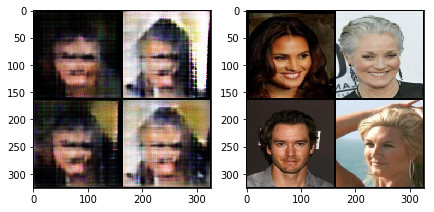

[0/1][1100/10130]	Loss_D: 1.0376	Loss_Dec: 3.3362	Aux F1: 0.8067	Loss_Enc: 4048.0964	D(x): 0.6003	D(G(z)): 0.3041
[0/1][1200/10130]	Loss_D: 1.0358	Loss_Dec: 3.3298	Aux F1: 0.8068	Loss_Enc: 3998.3224	D(x): 0.4967	D(G(z)): 0.2553
[0/1][1300/10130]	Loss_D: 1.0360	Loss_Dec: 3.3060	Aux F1: 0.8071	Loss_Enc: 3925.6871	D(x): 0.3942	D(G(z)): 0.3988
[0/1][1400/10130]	Loss_D: 1.0335	Loss_Dec: 3.2921	Aux F1: 0.8076	Loss_Enc: 3865.1041	D(x): 0.3896	D(G(z)): 0.4167
[0/1][1500/10130]	Loss_D: 1.0329	Loss_Dec: 3.2801	Aux F1: 0.8080	Loss_Enc: 3806.8718	D(x): 0.5000	D(G(z)): 0.2412
[0/1][1600/10130]	Loss_D: 1.0301	Loss_Dec: 3.2764	Aux F1: 0.8085	Loss_Enc: 3767.4678	D(x): 0.5815	D(G(z)): 0.2520
[0/1][1700/10130]	Loss_D: 1.0257	Loss_Dec: 3.2785	Aux F1: 0.8090	Loss_Enc: 3736.5408	D(x): 0.6240	D(G(z)): 0.2071
[0/1][1800/10130]	Loss_D: 1.0220	Loss_Dec: 3.2811	Aux F1: 0.8094	Loss_Enc: 3711.9747	D(x): 0.4646	D(G(z)): 0.2787
[0/1][1900/10130]	Loss_D: 1.0192	Loss_Dec: 3.2815	Aux F1: 0.8101	Loss_Enc: 3685.7082	D(x

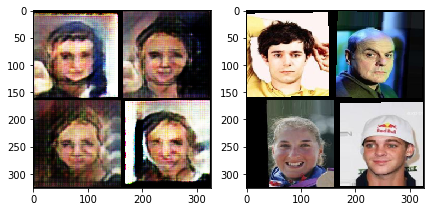

[0/1][2100/10130]	Loss_D: 1.0134	Loss_Dec: 3.2829	Aux F1: 0.8114	Loss_Enc: 3634.9904	D(x): 0.4713	D(G(z)): 0.2656
[0/1][2200/10130]	Loss_D: 1.0116	Loss_Dec: 3.2833	Aux F1: 0.8121	Loss_Enc: 3602.4426	D(x): 0.3898	D(G(z)): 0.3205
[0/1][2300/10130]	Loss_D: 1.0083	Loss_Dec: 3.2840	Aux F1: 0.8128	Loss_Enc: 3573.1237	D(x): 0.6822	D(G(z)): 0.2645
[0/1][2400/10130]	Loss_D: 1.0067	Loss_Dec: 3.2816	Aux F1: 0.8135	Loss_Enc: 3544.5454	D(x): 0.4911	D(G(z)): 0.3341
[0/1][2500/10130]	Loss_D: 1.0060	Loss_Dec: 3.2794	Aux F1: 0.8141	Loss_Enc: 3513.9907	D(x): 0.5796	D(G(z)): 0.3364
[0/1][2600/10130]	Loss_D: 1.0062	Loss_Dec: 3.2783	Aux F1: 0.8146	Loss_Enc: 3485.2534	D(x): 0.4820	D(G(z)): 0.2241
[0/1][2700/10130]	Loss_D: 1.0062	Loss_Dec: 3.2795	Aux F1: 0.8151	Loss_Enc: 3465.7661	D(x): 0.5080	D(G(z)): 0.2713
[0/1][2800/10130]	Loss_D: 1.0054	Loss_Dec: 3.2790	Aux F1: 0.8155	Loss_Enc: 3441.8006	D(x): 0.4297	D(G(z)): 0.3395
[0/1][2900/10130]	Loss_D: 1.0033	Loss_Dec: 3.2812	Aux F1: 0.8159	Loss_Enc: 3419.1823	D(x

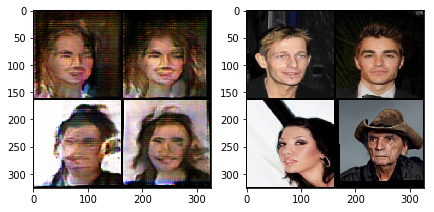

[0/1][3100/10130]	Loss_D: 0.9988	Loss_Dec: 3.2874	Aux F1: 0.8166	Loss_Enc: 3387.1440	D(x): 0.6283	D(G(z)): 0.2354
[0/1][3200/10130]	Loss_D: 0.9971	Loss_Dec: 3.2919	Aux F1: 0.8170	Loss_Enc: 3374.5701	D(x): 0.4417	D(G(z)): 0.3654
[0/1][3300/10130]	Loss_D: 0.9964	Loss_Dec: 3.2933	Aux F1: 0.8173	Loss_Enc: 3360.8460	D(x): 0.5232	D(G(z)): 0.2420
[0/1][3400/10130]	Loss_D: 0.9950	Loss_Dec: 3.2940	Aux F1: 0.8177	Loss_Enc: 3344.2866	D(x): 0.4805	D(G(z)): 0.2690
[0/1][3500/10130]	Loss_D: 0.9947	Loss_Dec: 3.2958	Aux F1: 0.8181	Loss_Enc: 3327.6325	D(x): 0.5473	D(G(z)): 0.2705
[0/1][3600/10130]	Loss_D: 0.9940	Loss_Dec: 3.2999	Aux F1: 0.8185	Loss_Enc: 3316.7836	D(x): 0.4794	D(G(z)): 0.3610
[0/1][3700/10130]	Loss_D: 0.9932	Loss_Dec: 3.3038	Aux F1: 0.8188	Loss_Enc: 3306.5445	D(x): 0.4149	D(G(z)): 0.3135
[0/1][3800/10130]	Loss_D: 0.9931	Loss_Dec: 3.3055	Aux F1: 0.8192	Loss_Enc: 3294.1993	D(x): 0.6391	D(G(z)): 0.3439
[0/1][3900/10130]	Loss_D: 0.9922	Loss_Dec: 3.3097	Aux F1: 0.8195	Loss_Enc: 3283.4342	D(x

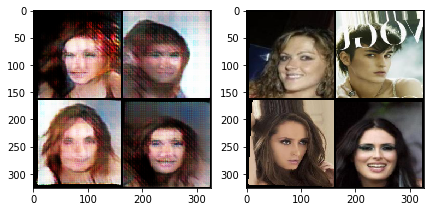

[0/1][4100/10130]	Loss_D: 0.9907	Loss_Dec: 3.3116	Aux F1: 0.8200	Loss_Enc: 3262.9214	D(x): 0.4422	D(G(z)): 0.4850
[0/1][4200/10130]	Loss_D: 0.9912	Loss_Dec: 3.3115	Aux F1: 0.8203	Loss_Enc: 3254.0231	D(x): 0.5440	D(G(z)): 0.2372
[0/1][4300/10130]	Loss_D: 0.9913	Loss_Dec: 3.3090	Aux F1: 0.8205	Loss_Enc: 3245.0070	D(x): 0.6212	D(G(z)): 0.3566
[0/1][4400/10130]	Loss_D: 0.9908	Loss_Dec: 3.3104	Aux F1: 0.8208	Loss_Enc: 3235.6887	D(x): 0.5142	D(G(z)): 0.4598
[0/1][4500/10130]	Loss_D: 0.9905	Loss_Dec: 3.3133	Aux F1: 0.8210	Loss_Enc: 3228.5257	D(x): 0.4591	D(G(z)): 0.3242
[0/1][4600/10130]	Loss_D: 0.9905	Loss_Dec: 3.3155	Aux F1: 0.8213	Loss_Enc: 3222.2432	D(x): 0.5934	D(G(z)): 0.2764
[0/1][4700/10130]	Loss_D: 0.9896	Loss_Dec: 3.3197	Aux F1: 0.8216	Loss_Enc: 3215.0252	D(x): 0.3731	D(G(z)): 0.3975
[0/1][4800/10130]	Loss_D: 0.9896	Loss_Dec: 3.3197	Aux F1: 0.8218	Loss_Enc: 3208.3504	D(x): 0.4497	D(G(z)): 0.2933
[0/1][4900/10130]	Loss_D: 0.9897	Loss_Dec: 3.3183	Aux F1: 0.8221	Loss_Enc: 3199.0794	D(x

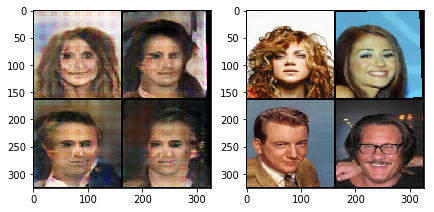

[0/1][5100/10130]	Loss_D: 0.9891	Loss_Dec: 3.3187	Aux F1: 0.8225	Loss_Enc: 3182.6507	D(x): 0.5699	D(G(z)): 0.2460
[0/1][5200/10130]	Loss_D: 0.9891	Loss_Dec: 3.3188	Aux F1: 0.8227	Loss_Enc: 3174.5027	D(x): 0.4768	D(G(z)): 0.4182
[0/1][5300/10130]	Loss_D: 0.9886	Loss_Dec: 3.3179	Aux F1: 0.8228	Loss_Enc: 3164.9979	D(x): 0.3555	D(G(z)): 0.4516
[0/1][5400/10130]	Loss_D: 0.9884	Loss_Dec: 3.3168	Aux F1: 0.8231	Loss_Enc: 3153.6249	D(x): 0.5653	D(G(z)): 0.3317
[0/1][5500/10130]	Loss_D: 0.9889	Loss_Dec: 3.3148	Aux F1: 0.8232	Loss_Enc: 3146.3639	D(x): 0.4578	D(G(z)): 0.3187
[0/1][5600/10130]	Loss_D: 0.9888	Loss_Dec: 3.3138	Aux F1: 0.8233	Loss_Enc: 3139.2173	D(x): 0.5001	D(G(z)): 0.3605
[0/1][5700/10130]	Loss_D: 0.9886	Loss_Dec: 3.3135	Aux F1: 0.8235	Loss_Enc: 3133.8293	D(x): 0.5282	D(G(z)): 0.3137
[0/1][5800/10130]	Loss_D: 0.9885	Loss_Dec: 3.3150	Aux F1: 0.8237	Loss_Enc: 3129.0535	D(x): 0.6633	D(G(z)): 0.2162
[0/1][5900/10130]	Loss_D: 0.9880	Loss_Dec: 3.3176	Aux F1: 0.8239	Loss_Enc: 3123.6017	D(x

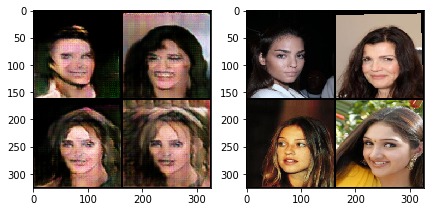

[0/1][6100/10130]	Loss_D: 0.9875	Loss_Dec: 3.3195	Aux F1: 0.8244	Loss_Enc: 3112.7743	D(x): 0.6750	D(G(z)): 0.2728
[0/1][6200/10130]	Loss_D: 0.9872	Loss_Dec: 3.3195	Aux F1: 0.8246	Loss_Enc: 3108.8111	D(x): 0.5332	D(G(z)): 0.2939
[0/1][6300/10130]	Loss_D: 0.9873	Loss_Dec: 3.3183	Aux F1: 0.8248	Loss_Enc: 3104.3254	D(x): 0.5587	D(G(z)): 0.3550
[0/1][6400/10130]	Loss_D: 0.9863	Loss_Dec: 3.3190	Aux F1: 0.8249	Loss_Enc: 3100.2932	D(x): 0.4848	D(G(z)): 0.3225
[0/1][6500/10130]	Loss_D: 0.9859	Loss_Dec: 3.3199	Aux F1: 0.8251	Loss_Enc: 3094.4198	D(x): 0.5673	D(G(z)): 0.2506
[0/1][6600/10130]	Loss_D: 0.9861	Loss_Dec: 3.3191	Aux F1: 0.8253	Loss_Enc: 3089.5478	D(x): 0.5596	D(G(z)): 0.3003
[0/1][6700/10130]	Loss_D: 0.9859	Loss_Dec: 3.3206	Aux F1: 0.8254	Loss_Enc: 3083.2522	D(x): 0.6262	D(G(z)): 0.2225
[0/1][6800/10130]	Loss_D: 0.9860	Loss_Dec: 3.3213	Aux F1: 0.8256	Loss_Enc: 3079.4913	D(x): 0.4376	D(G(z)): 0.3141
[0/1][6900/10130]	Loss_D: 0.9858	Loss_Dec: 3.3235	Aux F1: 0.8258	Loss_Enc: 3075.7368	D(x

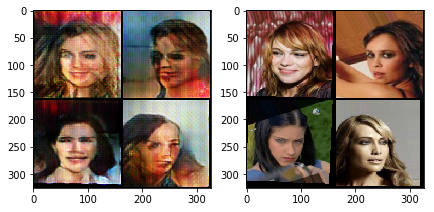

[0/1][7100/10130]	Loss_D: 0.9848	Loss_Dec: 3.3265	Aux F1: 0.8261	Loss_Enc: 3063.8877	D(x): 0.3585	D(G(z)): 0.4248
[0/1][7200/10130]	Loss_D: 0.9848	Loss_Dec: 3.3255	Aux F1: 0.8263	Loss_Enc: 3059.6585	D(x): 0.4256	D(G(z)): 0.3330
[0/1][7300/10130]	Loss_D: 0.9847	Loss_Dec: 3.3252	Aux F1: 0.8265	Loss_Enc: 3055.4065	D(x): 0.5443	D(G(z)): 0.2432
[0/1][7400/10130]	Loss_D: 0.9843	Loss_Dec: 3.3260	Aux F1: 0.8266	Loss_Enc: 3049.9200	D(x): 0.3675	D(G(z)): 0.4133
[0/1][7500/10130]	Loss_D: 0.9836	Loss_Dec: 3.3279	Aux F1: 0.8268	Loss_Enc: 3043.9141	D(x): 0.4614	D(G(z)): 0.3130
[0/1][7600/10130]	Loss_D: 0.9841	Loss_Dec: 3.3260	Aux F1: 0.8269	Loss_Enc: 3038.1207	D(x): 0.4051	D(G(z)): 0.3077
[0/1][7700/10130]	Loss_D: 0.9833	Loss_Dec: 3.3270	Aux F1: 0.8271	Loss_Enc: 3034.0321	D(x): 0.5623	D(G(z)): 0.3508
[0/1][7800/10130]	Loss_D: 0.9824	Loss_Dec: 3.3315	Aux F1: 0.8272	Loss_Enc: 3032.7436	D(x): 0.4308	D(G(z)): 0.4220
[0/1][7900/10130]	Loss_D: 0.9822	Loss_Dec: 3.3346	Aux F1: 0.8274	Loss_Enc: 3030.6375	D(x

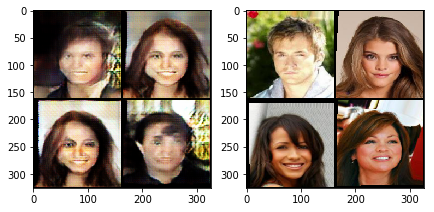

[0/1][8100/10130]	Loss_D: 0.9819	Loss_Dec: 3.3373	Aux F1: 0.8277	Loss_Enc: 3023.7190	D(x): 0.4582	D(G(z)): 0.2415
[0/1][8200/10130]	Loss_D: 0.9819	Loss_Dec: 3.3384	Aux F1: 0.8279	Loss_Enc: 3020.7085	D(x): 0.5297	D(G(z)): 0.2178
[0/1][8300/10130]	Loss_D: 0.9816	Loss_Dec: 3.3384	Aux F1: 0.8280	Loss_Enc: 3017.2412	D(x): 0.5169	D(G(z)): 0.3105
[0/1][8400/10130]	Loss_D: 0.9818	Loss_Dec: 3.3376	Aux F1: 0.8282	Loss_Enc: 3012.3426	D(x): 0.3942	D(G(z)): 0.3542
[0/1][8500/10130]	Loss_D: 0.9818	Loss_Dec: 3.3371	Aux F1: 0.8283	Loss_Enc: 3007.3149	D(x): 0.4749	D(G(z)): 0.2822
[0/1][8600/10130]	Loss_D: 0.9814	Loss_Dec: 3.3371	Aux F1: 0.8284	Loss_Enc: 3004.4519	D(x): 0.6524	D(G(z)): 0.2272
[0/1][8700/10130]	Loss_D: 0.9808	Loss_Dec: 3.3390	Aux F1: 0.8286	Loss_Enc: 3000.0499	D(x): 0.4962	D(G(z)): 0.3020
[0/1][8800/10130]	Loss_D: 0.9803	Loss_Dec: 3.3409	Aux F1: 0.8287	Loss_Enc: 2995.7832	D(x): 0.5136	D(G(z)): 0.2424
[0/1][8900/10130]	Loss_D: 0.9799	Loss_Dec: 3.3420	Aux F1: 0.8288	Loss_Enc: 2991.5152	D(x

In [0]:
train(net, n_epochs=1, train_loader=train_loader)

[0/1][0/10130]	Loss_D: 0.8532	Loss_Dec: 3.5579	Aux F1: 0.8387	Loss_Enc: 2920.0571	D(x): 0.5953	D(G(z)): 0.2243
[0/1][100/10130]	Loss_D: 0.9120	Loss_Dec: 3.5294	Aux F1: 0.8418	Loss_Enc: 2717.0843	D(x): 0.6130	D(G(z)): 0.1929
[0/1][200/10130]	Loss_D: 0.9587	Loss_Dec: 3.4617	Aux F1: 0.8403	Loss_Enc: 2709.7333	D(x): 0.5116	D(G(z)): 0.3302
[0/1][300/10130]	Loss_D: 0.9562	Loss_Dec: 3.4072	Aux F1: 0.8405	Loss_Enc: 2702.0083	D(x): 0.5076	D(G(z)): 0.3499
[0/1][400/10130]	Loss_D: 0.9566	Loss_Dec: 3.3862	Aux F1: 0.8399	Loss_Enc: 2724.1027	D(x): 0.6812	D(G(z)): 0.1630
[0/1][500/10130]	Loss_D: 0.9453	Loss_Dec: 3.4291	Aux F1: 0.8400	Loss_Enc: 2698.4717	D(x): 0.6443	D(G(z)): 0.1982
[0/1][600/10130]	Loss_D: 0.9455	Loss_Dec: 3.4461	Aux F1: 0.8405	Loss_Enc: 2661.3909	D(x): 0.4420	D(G(z)): 0.2838
[0/1][700/10130]	Loss_D: 0.9419	Loss_Dec: 3.4560	Aux F1: 0.8412	Loss_Enc: 2662.2114	D(x): 0.5428	D(G(z)): 0.2742
[0/1][800/10130]	Loss_D: 0.9474	Loss_Dec: 3.4582	Aux F1: 0.8412	Loss_Enc: 2684.3913	D(x): 0.4081	D

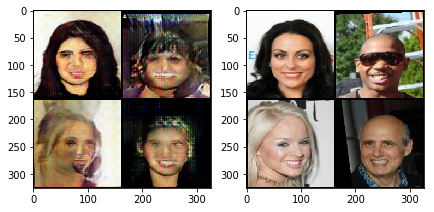

[0/1][1100/10130]	Loss_D: 0.9475	Loss_Dec: 3.4633	Aux F1: 0.8413	Loss_Enc: 2697.5107	D(x): 0.6208	D(G(z)): 0.2713
[0/1][1200/10130]	Loss_D: 0.9477	Loss_Dec: 3.4632	Aux F1: 0.8413	Loss_Enc: 2702.0279	D(x): 0.4422	D(G(z)): 0.3609
[0/1][1300/10130]	Loss_D: 0.9494	Loss_Dec: 3.4677	Aux F1: 0.8415	Loss_Enc: 2691.4882	D(x): 0.5843	D(G(z)): 0.2673
[0/1][1400/10130]	Loss_D: 0.9446	Loss_Dec: 3.4850	Aux F1: 0.8415	Loss_Enc: 2682.7648	D(x): 0.4987	D(G(z)): 0.2739
[0/1][1500/10130]	Loss_D: 0.9442	Loss_Dec: 3.4890	Aux F1: 0.8416	Loss_Enc: 2676.7095	D(x): 0.5841	D(G(z)): 0.3038
[0/1][1600/10130]	Loss_D: 0.9455	Loss_Dec: 3.4884	Aux F1: 0.8417	Loss_Enc: 2674.1152	D(x): 0.4880	D(G(z)): 0.2792
[0/1][1700/10130]	Loss_D: 0.9446	Loss_Dec: 3.4893	Aux F1: 0.8421	Loss_Enc: 2668.8895	D(x): 0.5243	D(G(z)): 0.2894
[0/1][1800/10130]	Loss_D: 0.9461	Loss_Dec: 3.4876	Aux F1: 0.8420	Loss_Enc: 2666.5820	D(x): 0.5914	D(G(z)): 0.2223
[0/1][1900/10130]	Loss_D: 0.9452	Loss_Dec: 3.4869	Aux F1: 0.8421	Loss_Enc: 2665.7026	D(x

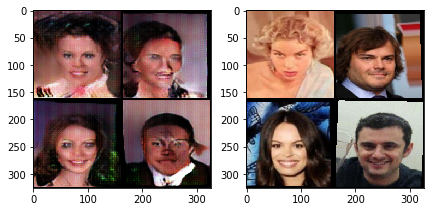

[0/1][2100/10130]	Loss_D: 0.9431	Loss_Dec: 3.4940	Aux F1: 0.8423	Loss_Enc: 2660.8740	D(x): 0.5924	D(G(z)): 0.2573
[0/1][2200/10130]	Loss_D: 0.9414	Loss_Dec: 3.4960	Aux F1: 0.8423	Loss_Enc: 2661.7366	D(x): 0.5110	D(G(z)): 0.2937
[0/1][2300/10130]	Loss_D: 0.9410	Loss_Dec: 3.4981	Aux F1: 0.8423	Loss_Enc: 2657.1926	D(x): 0.6961	D(G(z)): 0.2022
[0/1][2400/10130]	Loss_D: 0.9405	Loss_Dec: 3.4964	Aux F1: 0.8424	Loss_Enc: 2652.6616	D(x): 0.6083	D(G(z)): 0.2187
[0/1][2500/10130]	Loss_D: 0.9415	Loss_Dec: 3.4914	Aux F1: 0.8426	Loss_Enc: 2646.8413	D(x): 0.5814	D(G(z)): 0.2378
[0/1][2600/10130]	Loss_D: 0.9419	Loss_Dec: 3.4910	Aux F1: 0.8427	Loss_Enc: 2642.7931	D(x): 0.6205	D(G(z)): 0.1753
[0/1][2700/10130]	Loss_D: 0.9418	Loss_Dec: 3.4942	Aux F1: 0.8429	Loss_Enc: 2644.4908	D(x): 0.6797	D(G(z)): 0.1731
[0/1][2800/10130]	Loss_D: 0.9396	Loss_Dec: 3.4990	Aux F1: 0.8430	Loss_Enc: 2646.4909	D(x): 0.5964	D(G(z)): 0.3220
[0/1][2900/10130]	Loss_D: 0.9386	Loss_Dec: 3.4998	Aux F1: 0.8432	Loss_Enc: 2647.1627	D(x

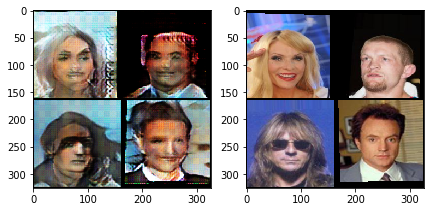

[0/1][3100/10130]	Loss_D: 0.9381	Loss_Dec: 3.5024	Aux F1: 0.8434	Loss_Enc: 2651.9224	D(x): 0.5028	D(G(z)): 0.3197
[0/1][3200/10130]	Loss_D: 0.9379	Loss_Dec: 3.5020	Aux F1: 0.8435	Loss_Enc: 2654.9517	D(x): 0.5311	D(G(z)): 0.2989
[0/1][3300/10130]	Loss_D: 0.9372	Loss_Dec: 3.5029	Aux F1: 0.8436	Loss_Enc: 2656.6327	D(x): 0.4351	D(G(z)): 0.3813
[0/1][3400/10130]	Loss_D: 0.9367	Loss_Dec: 3.5066	Aux F1: 0.8437	Loss_Enc: 2655.2639	D(x): 0.6061	D(G(z)): 0.1994
[0/1][3500/10130]	Loss_D: 0.9371	Loss_Dec: 3.5082	Aux F1: 0.8438	Loss_Enc: 2654.2342	D(x): 0.5913	D(G(z)): 0.2400
[0/1][3600/10130]	Loss_D: 0.9366	Loss_Dec: 3.5130	Aux F1: 0.8439	Loss_Enc: 2653.8984	D(x): 0.6409	D(G(z)): 0.1985
[0/1][3700/10130]	Loss_D: 0.9360	Loss_Dec: 3.5171	Aux F1: 0.8440	Loss_Enc: 2652.4436	D(x): 0.5389	D(G(z)): 0.2488
[0/1][3800/10130]	Loss_D: 0.9346	Loss_Dec: 3.5231	Aux F1: 0.8440	Loss_Enc: 2652.7105	D(x): 0.5102	D(G(z)): 0.2264
[0/1][3900/10130]	Loss_D: 0.9329	Loss_Dec: 3.5306	Aux F1: 0.8442	Loss_Enc: 2653.3865	D(x

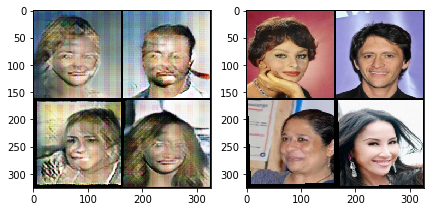

[0/1][4100/10130]	Loss_D: 0.9324	Loss_Dec: 3.5355	Aux F1: 0.8443	Loss_Enc: 2650.9898	D(x): 0.5692	D(G(z)): 0.2647
[0/1][4200/10130]	Loss_D: 0.9309	Loss_Dec: 3.5408	Aux F1: 0.8444	Loss_Enc: 2650.8234	D(x): 0.5171	D(G(z)): 0.2949
[0/1][4300/10130]	Loss_D: 0.9305	Loss_Dec: 3.5440	Aux F1: 0.8446	Loss_Enc: 2651.5625	D(x): 0.4519	D(G(z)): 0.3398
[0/1][4400/10130]	Loss_D: 0.9309	Loss_Dec: 3.5425	Aux F1: 0.8447	Loss_Enc: 2649.9834	D(x): 0.5219	D(G(z)): 0.3469
[0/1][4500/10130]	Loss_D: 0.9318	Loss_Dec: 3.5434	Aux F1: 0.8448	Loss_Enc: 2648.8960	D(x): 0.6751	D(G(z)): 0.2888
[0/1][4600/10130]	Loss_D: 0.9305	Loss_Dec: 3.5479	Aux F1: 0.8449	Loss_Enc: 2647.8732	D(x): 0.5974	D(G(z)): 0.2688
[0/1][4700/10130]	Loss_D: 0.9312	Loss_Dec: 3.5483	Aux F1: 0.8451	Loss_Enc: 2650.4387	D(x): 0.5096	D(G(z)): 0.4313
[0/1][4800/10130]	Loss_D: 0.9321	Loss_Dec: 3.5492	Aux F1: 0.8452	Loss_Enc: 2652.6762	D(x): 0.4230	D(G(z)): 0.3994
[0/1][4900/10130]	Loss_D: 0.9329	Loss_Dec: 3.5480	Aux F1: 0.8453	Loss_Enc: 2656.0050	D(x

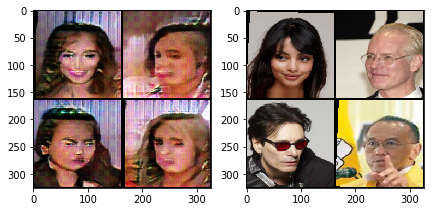

[0/1][5100/10130]	Loss_D: 0.9344	Loss_Dec: 3.5512	Aux F1: 0.8455	Loss_Enc: 2657.9547	D(x): 0.4456	D(G(z)): 0.3134
[0/1][5200/10130]	Loss_D: 0.9354	Loss_Dec: 3.5485	Aux F1: 0.8456	Loss_Enc: 2658.6409	D(x): 0.5355	D(G(z)): 0.2504
[0/1][5300/10130]	Loss_D: 0.9354	Loss_Dec: 3.5497	Aux F1: 0.8458	Loss_Enc: 2659.8082	D(x): 0.6071	D(G(z)): 0.2523
[0/1][5400/10130]	Loss_D: 0.9357	Loss_Dec: 3.5512	Aux F1: 0.8460	Loss_Enc: 2660.2167	D(x): 0.5590	D(G(z)): 0.3385
[0/1][5500/10130]	Loss_D: 0.9365	Loss_Dec: 3.5485	Aux F1: 0.8461	Loss_Enc: 2660.1461	D(x): 0.6080	D(G(z)): 0.3679
[0/1][5600/10130]	Loss_D: 0.9360	Loss_Dec: 3.5515	Aux F1: 0.8461	Loss_Enc: 2661.7380	D(x): 0.4790	D(G(z)): 0.3626
[0/1][5700/10130]	Loss_D: 0.9369	Loss_Dec: 3.5504	Aux F1: 0.8462	Loss_Enc: 2662.7367	D(x): 0.4589	D(G(z)): 0.2602
[0/1][5800/10130]	Loss_D: 0.9377	Loss_Dec: 3.5483	Aux F1: 0.8463	Loss_Enc: 2661.2897	D(x): 0.5145	D(G(z)): 0.2990
[0/1][5900/10130]	Loss_D: 0.9389	Loss_Dec: 3.5476	Aux F1: 0.8464	Loss_Enc: 2659.6329	D(x

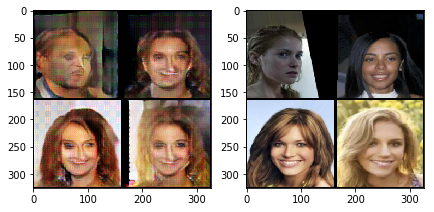

[0/1][6100/10130]	Loss_D: 0.9400	Loss_Dec: 3.5454	Aux F1: 0.8467	Loss_Enc: 2663.9088	D(x): 0.5287	D(G(z)): 0.3159
[0/1][6200/10130]	Loss_D: 0.9407	Loss_Dec: 3.5450	Aux F1: 0.8468	Loss_Enc: 2664.3484	D(x): 0.5240	D(G(z)): 0.4002
[0/1][6300/10130]	Loss_D: 0.9411	Loss_Dec: 3.5444	Aux F1: 0.8469	Loss_Enc: 2665.1074	D(x): 0.4875	D(G(z)): 0.2642
[0/1][6400/10130]	Loss_D: 0.9417	Loss_Dec: 3.5426	Aux F1: 0.8471	Loss_Enc: 2662.1561	D(x): 0.5571	D(G(z)): 0.1759
[0/1][6500/10130]	Loss_D: 0.9411	Loss_Dec: 3.5409	Aux F1: 0.8472	Loss_Enc: 2661.2611	D(x): 0.5588	D(G(z)): 0.3266
[0/1][6600/10130]	Loss_D: 0.9411	Loss_Dec: 3.5397	Aux F1: 0.8473	Loss_Enc: 2658.5983	D(x): 0.5768	D(G(z)): 0.3435
[0/1][6700/10130]	Loss_D: 0.9406	Loss_Dec: 3.5398	Aux F1: 0.8475	Loss_Enc: 2657.3861	D(x): 0.5646	D(G(z)): 0.2849
[0/1][6800/10130]	Loss_D: 0.9408	Loss_Dec: 3.5388	Aux F1: 0.8477	Loss_Enc: 2656.3556	D(x): 0.6824	D(G(z)): 0.1786
[0/1][6900/10130]	Loss_D: 0.9406	Loss_Dec: 3.5369	Aux F1: 0.8477	Loss_Enc: 2657.2279	D(x

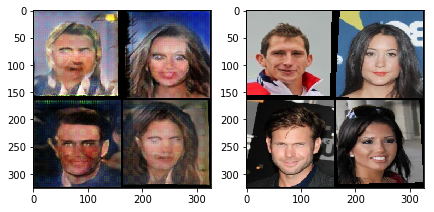

[0/1][7100/10130]	Loss_D: 0.9397	Loss_Dec: 3.5376	Aux F1: 0.8480	Loss_Enc: 2653.4069	D(x): 0.6099	D(G(z)): 0.2243
[0/1][7200/10130]	Loss_D: 0.9398	Loss_Dec: 3.5361	Aux F1: 0.8481	Loss_Enc: 2650.8680	D(x): 0.6076	D(G(z)): 0.3089
[0/1][7300/10130]	Loss_D: 0.9397	Loss_Dec: 3.5349	Aux F1: 0.8482	Loss_Enc: 2648.5506	D(x): 0.5584	D(G(z)): 0.2901
[0/1][7400/10130]	Loss_D: 0.9394	Loss_Dec: 3.5360	Aux F1: 0.8483	Loss_Enc: 2646.8924	D(x): 0.5099	D(G(z)): 0.2300
[0/1][7500/10130]	Loss_D: 0.9395	Loss_Dec: 3.5350	Aux F1: 0.8484	Loss_Enc: 2645.1175	D(x): 0.6973	D(G(z)): 0.1656
[0/1][7600/10130]	Loss_D: 0.9393	Loss_Dec: 3.5340	Aux F1: 0.8485	Loss_Enc: 2642.2722	D(x): 0.6193	D(G(z)): 0.2504
[0/1][7700/10130]	Loss_D: 0.9385	Loss_Dec: 3.5346	Aux F1: 0.8486	Loss_Enc: 2640.9622	D(x): 0.5831	D(G(z)): 0.2550
[0/1][7800/10130]	Loss_D: 0.9380	Loss_Dec: 3.5355	Aux F1: 0.8487	Loss_Enc: 2639.5068	D(x): 0.5037	D(G(z)): 0.2931
[0/1][7900/10130]	Loss_D: 0.9387	Loss_Dec: 3.5352	Aux F1: 0.8489	Loss_Enc: 2637.2045	D(x

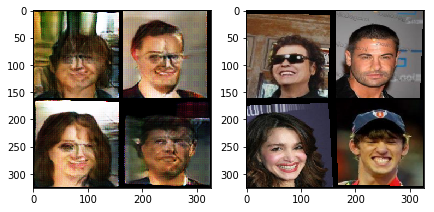

[0/1][8100/10130]	Loss_D: 0.9382	Loss_Dec: 3.5367	Aux F1: 0.8491	Loss_Enc: 2634.9908	D(x): 0.6832	D(G(z)): 0.2411
[0/1][8200/10130]	Loss_D: 0.9375	Loss_Dec: 3.5375	Aux F1: 0.8492	Loss_Enc: 2634.2912	D(x): 0.5068	D(G(z)): 0.2741
[0/1][8300/10130]	Loss_D: 0.9365	Loss_Dec: 3.5409	Aux F1: 0.8493	Loss_Enc: 2634.9040	D(x): 0.5521	D(G(z)): 0.2187
[0/1][8400/10130]	Loss_D: 0.9363	Loss_Dec: 3.5423	Aux F1: 0.8494	Loss_Enc: 2634.8951	D(x): 0.4609	D(G(z)): 0.3466
[0/1][8500/10130]	Loss_D: 0.9358	Loss_Dec: 3.5427	Aux F1: 0.8495	Loss_Enc: 2635.2298	D(x): 0.5896	D(G(z)): 0.2058
[0/1][8600/10130]	Loss_D: 0.9366	Loss_Dec: 3.5422	Aux F1: 0.8496	Loss_Enc: 2633.1790	D(x): 0.4489	D(G(z)): 0.3178
[0/1][8700/10130]	Loss_D: 0.9363	Loss_Dec: 3.5423	Aux F1: 0.8497	Loss_Enc: 2632.5087	D(x): 0.5460	D(G(z)): 0.2314
[0/1][8800/10130]	Loss_D: 0.9359	Loss_Dec: 3.5444	Aux F1: 0.8498	Loss_Enc: 2631.7962	D(x): 0.5510	D(G(z)): 0.2876
[0/1][8900/10130]	Loss_D: 0.9347	Loss_Dec: 3.5480	Aux F1: 0.8499	Loss_Enc: 2631.4394	D(x

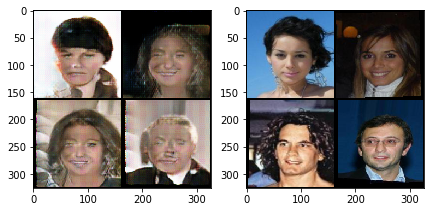

Interrupting... Saving model...
Copying file://./vaegan_dn201_2.pt [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

/
Operation completed over 1 objects/195.7 MiB.                                    
Copying file://./vaegan_dn201_opt_disc_2.pt [Content-Type=application/octet-stream]...
\
Operation completed over 1 objects/69.4 M

In [0]:
train(net, n_epochs=1, train_loader=train_loader)

In [0]:
lr_encoder.step()
lr_decoder.step()
lr_discriminator.step()

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:100: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


In [0]:
for pg in optimizer_discriminator.param_groups:
  pg['lr'] *= 0.5

for pg in optimizer_decoder.param_groups:
  pg['lr'] *= 0.5  

for pg in optimizer_encoder.param_groups:
  pg['lr'] *= 0.5  

[0/1][0/7585]	Loss_D: 0.9159	Loss_Dec: 3.6852	Aux F1: 0.8943	Loss_Enc: 2406.2632	D(x): 0.5638	D(G(z)): 0.2893
[0/1][200/7585]	Loss_D: 0.9463	Loss_Dec: 3.4732	Aux F1: 0.8868	Loss_Enc: 2266.9446	D(x): 0.4264	D(G(z)): 0.3770
[0/1][400/7585]	Loss_D: 0.9338	Loss_Dec: 3.5711	Aux F1: 0.8878	Loss_Enc: 2232.0275	D(x): 0.4713	D(G(z)): 0.3530
[0/1][600/7585]	Loss_D: 0.9557	Loss_Dec: 3.5354	Aux F1: 0.8879	Loss_Enc: 2171.7341	D(x): 0.5545	D(G(z)): 0.2652
[0/1][800/7585]	Loss_D: 0.9644	Loss_Dec: 3.4885	Aux F1: 0.8881	Loss_Enc: 2159.9262	D(x): 0.4719	D(G(z)): 0.3553
[0/1][1000/7585]	Loss_D: 0.9601	Loss_Dec: 3.4847	Aux F1: 0.8883	Loss_Enc: 2178.6135	D(x): 0.5143	D(G(z)): 0.2932
[0/1][1200/7585]	Loss_D: 0.9559	Loss_Dec: 3.5041	Aux F1: 0.8887	Loss_Enc: 2198.0948	D(x): 0.5552	D(G(z)): 0.2742
[0/1][1400/7585]	Loss_D: 0.9618	Loss_Dec: 3.4902	Aux F1: 0.8889	Loss_Enc: 2181.2609	D(x): 0.5650	D(G(z)): 0.3453
[0/1][1600/7585]	Loss_D: 0.9631	Loss_Dec: 3.4908	Aux F1: 0.8891	Loss_Enc: 2170.0508	D(x): 0.5554	D(G(z)

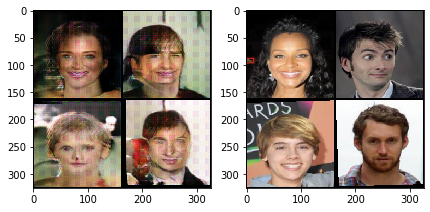

[0/1][2200/7585]	Loss_D: 0.9642	Loss_Dec: 3.4860	Aux F1: 0.8898	Loss_Enc: 2125.6041	D(x): 0.5373	D(G(z)): 0.2825
[0/1][2400/7585]	Loss_D: 0.9620	Loss_Dec: 3.4867	Aux F1: 0.8900	Loss_Enc: 2126.4410	D(x): 0.5320	D(G(z)): 0.2563
[0/1][2600/7585]	Loss_D: 0.9654	Loss_Dec: 3.4856	Aux F1: 0.8902	Loss_Enc: 2116.4953	D(x): 0.5417	D(G(z)): 0.3161
[0/1][2800/7585]	Loss_D: 0.9647	Loss_Dec: 3.4790	Aux F1: 0.8903	Loss_Enc: 2104.1908	D(x): 0.5142	D(G(z)): 0.3547
[0/1][3000/7585]	Loss_D: 0.9611	Loss_Dec: 3.4816	Aux F1: 0.8904	Loss_Enc: 2105.2596	D(x): 0.6681	D(G(z)): 0.2457
[0/1][3200/7585]	Loss_D: 0.9586	Loss_Dec: 3.4786	Aux F1: 0.8905	Loss_Enc: 2109.7348	D(x): 0.6198	D(G(z)): 0.2603
[0/1][3400/7585]	Loss_D: 0.9569	Loss_Dec: 3.4793	Aux F1: 0.8906	Loss_Enc: 2113.8802	D(x): 0.6094	D(G(z)): 0.2376
[0/1][3600/7585]	Loss_D: 0.9560	Loss_Dec: 3.4770	Aux F1: 0.8908	Loss_Enc: 2118.3945	D(x): 0.5788	D(G(z)): 0.2588
[0/1][3800/7585]	Loss_D: 0.9542	Loss_Dec: 3.4802	Aux F1: 0.8909	Loss_Enc: 2119.6548	D(x): 0.4262

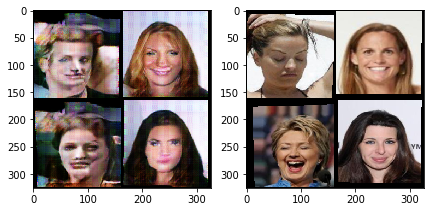

[0/1][4200/7585]	Loss_D: 0.9560	Loss_Dec: 3.4718	Aux F1: 0.8911	Loss_Enc: 2128.0403	D(x): 0.5974	D(G(z)): 0.3055
[0/1][4400/7585]	Loss_D: 0.9584	Loss_Dec: 3.4678	Aux F1: 0.8913	Loss_Enc: 2129.2237	D(x): 0.4557	D(G(z)): 0.3384
[0/1][4600/7585]	Loss_D: 0.9606	Loss_Dec: 3.4631	Aux F1: 0.8914	Loss_Enc: 2125.9322	D(x): 0.4369	D(G(z)): 0.3625
[0/1][4800/7585]	Loss_D: 0.9625	Loss_Dec: 3.4587	Aux F1: 0.8916	Loss_Enc: 2122.2563	D(x): 0.4592	D(G(z)): 0.3496
[0/1][5000/7585]	Loss_D: 0.9622	Loss_Dec: 3.4549	Aux F1: 0.8917	Loss_Enc: 2117.0535	D(x): 0.5132	D(G(z)): 0.2277
[0/1][5200/7585]	Loss_D: 0.9623	Loss_Dec: 3.4574	Aux F1: 0.8918	Loss_Enc: 2117.3704	D(x): 0.4662	D(G(z)): 0.2955
[0/1][5400/7585]	Loss_D: 0.9623	Loss_Dec: 3.4623	Aux F1: 0.8919	Loss_Enc: 2119.5064	D(x): 0.5182	D(G(z)): 0.2227
[0/1][5600/7585]	Loss_D: 0.9620	Loss_Dec: 3.4633	Aux F1: 0.8920	Loss_Enc: 2119.8866	D(x): 0.4930	D(G(z)): 0.2998
[0/1][5800/7585]	Loss_D: 0.9611	Loss_Dec: 3.4641	Aux F1: 0.8920	Loss_Enc: 2119.7519	D(x): 0.5342

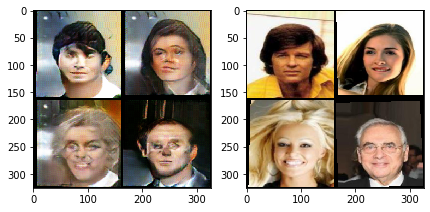

[0/1][6200/7585]	Loss_D: 0.9629	Loss_Dec: 3.4657	Aux F1: 0.8922	Loss_Enc: 2122.0403	D(x): 0.5366	D(G(z)): 0.2183
[0/1][6400/7585]	Loss_D: 0.9634	Loss_Dec: 3.4683	Aux F1: 0.8923	Loss_Enc: 2122.2095	D(x): 0.5001	D(G(z)): 0.3625
[0/1][6600/7585]	Loss_D: 0.9650	Loss_Dec: 3.4660	Aux F1: 0.8925	Loss_Enc: 2123.3783	D(x): 0.5009	D(G(z)): 0.3398
[0/1][6800/7585]	Loss_D: 0.9646	Loss_Dec: 3.4642	Aux F1: 0.8926	Loss_Enc: 2122.3039	D(x): 0.5529	D(G(z)): 0.1581
[0/1][7000/7585]	Loss_D: 0.9640	Loss_Dec: 3.4663	Aux F1: 0.8927	Loss_Enc: 2121.9946	D(x): 0.4878	D(G(z)): 0.2445
[0/1][7200/7585]	Loss_D: 0.9634	Loss_Dec: 3.4678	Aux F1: 0.8927	Loss_Enc: 2122.0954	D(x): 0.5488	D(G(z)): 0.2613
Interrupting... Saving model...
Copying file://./vaegan_dn201_2.pt [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshol

In [0]:
train(net, n_epochs=1, train_loader=train_loader)

[0/1][0/7585]	Loss_D: 1.1316	Loss_Dec: 3.3903	Aux F1: 0.9182	Loss_Enc: 2157.0493	D(x): 0.4787	D(G(z)): 0.3106
[0/1][200/7585]	Loss_D: 1.0007	Loss_Dec: 3.3902	Aux F1: 0.9119	Loss_Enc: 2130.5717	D(x): 0.4975	D(G(z)): 0.2369
[0/1][400/7585]	Loss_D: 1.0047	Loss_Dec: 3.3739	Aux F1: 0.9116	Loss_Enc: 2113.6212	D(x): 0.5969	D(G(z)): 0.2298
[0/1][600/7585]	Loss_D: 0.9739	Loss_Dec: 3.4330	Aux F1: 0.9108	Loss_Enc: 2132.9669	D(x): 0.6237	D(G(z)): 0.2240
[0/1][800/7585]	Loss_D: 0.9556	Loss_Dec: 3.5330	Aux F1: 0.9105	Loss_Enc: 2158.0600	D(x): 0.5531	D(G(z)): 0.3165
[0/1][1000/7585]	Loss_D: 0.9613	Loss_Dec: 3.5591	Aux F1: 0.9106	Loss_Enc: 2155.6468	D(x): 0.4974	D(G(z)): 0.2605
[0/1][1200/7585]	Loss_D: 0.9634	Loss_Dec: 3.5418	Aux F1: 0.9106	Loss_Enc: 2151.2841	D(x): 0.4527	D(G(z)): 0.3302
[0/1][1400/7585]	Loss_D: 0.9623	Loss_Dec: 3.5399	Aux F1: 0.9105	Loss_Enc: 2153.2872	D(x): 0.5537	D(G(z)): 0.2548
[0/1][1600/7585]	Loss_D: 0.9619	Loss_Dec: 3.5249	Aux F1: 0.9105	Loss_Enc: 2164.7756	D(x): 0.5631	D(G(z)

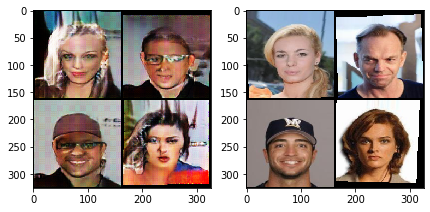

[0/1][2200/7585]	Loss_D: 0.9584	Loss_Dec: 3.5260	Aux F1: 0.9103	Loss_Enc: 2170.4227	D(x): 0.5738	D(G(z)): 0.2740
[0/1][2400/7585]	Loss_D: 0.9555	Loss_Dec: 3.5436	Aux F1: 0.9102	Loss_Enc: 2177.7407	D(x): 0.5426	D(G(z)): 0.2675
[0/1][2600/7585]	Loss_D: 0.9578	Loss_Dec: 3.5401	Aux F1: 0.9102	Loss_Enc: 2172.9100	D(x): 0.5896	D(G(z)): 0.2394
[0/1][2800/7585]	Loss_D: 0.9561	Loss_Dec: 3.5339	Aux F1: 0.9102	Loss_Enc: 2174.3114	D(x): 0.5546	D(G(z)): 0.3035
[0/1][3000/7585]	Loss_D: 0.9598	Loss_Dec: 3.5219	Aux F1: 0.9101	Loss_Enc: 2176.2123	D(x): 0.6002	D(G(z)): 0.2854
[0/1][3200/7585]	Loss_D: 0.9598	Loss_Dec: 3.5124	Aux F1: 0.9102	Loss_Enc: 2180.2629	D(x): 0.6038	D(G(z)): 0.2695
[0/1][3400/7585]	Loss_D: 0.9522	Loss_Dec: 3.5209	Aux F1: 0.9102	Loss_Enc: 2186.7180	D(x): 0.5912	D(G(z)): 0.2410
[0/1][3600/7585]	Loss_D: 0.9518	Loss_Dec: 3.5305	Aux F1: 0.9103	Loss_Enc: 2189.7950	D(x): 0.5536	D(G(z)): 0.2905
[0/1][3800/7585]	Loss_D: 0.9483	Loss_Dec: 3.5402	Aux F1: 0.9102	Loss_Enc: 2189.9234	D(x): 0.5397

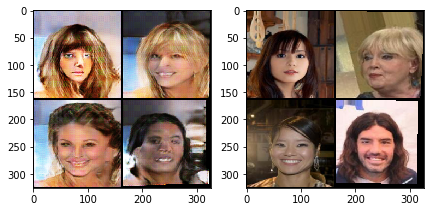

[0/1][4200/7585]	Loss_D: 0.9489	Loss_Dec: 3.5396	Aux F1: 0.9102	Loss_Enc: 2189.1882	D(x): 0.6370	D(G(z)): 0.2234
[0/1][4400/7585]	Loss_D: 0.9495	Loss_Dec: 3.5364	Aux F1: 0.9102	Loss_Enc: 2188.0854	D(x): 0.4923	D(G(z)): 0.3318
[0/1][4600/7585]	Loss_D: 0.9510	Loss_Dec: 3.5299	Aux F1: 0.9102	Loss_Enc: 2191.1633	D(x): 0.5493	D(G(z)): 0.3460
[0/1][4800/7585]	Loss_D: 0.9498	Loss_Dec: 3.5256	Aux F1: 0.9102	Loss_Enc: 2193.9761	D(x): 0.5382	D(G(z)): 0.2787
[0/1][5000/7585]	Loss_D: 0.9509	Loss_Dec: 3.5241	Aux F1: 0.9102	Loss_Enc: 2194.0028	D(x): 0.6267	D(G(z)): 0.2192
[0/1][5200/7585]	Loss_D: 0.9537	Loss_Dec: 3.5234	Aux F1: 0.9102	Loss_Enc: 2193.8049	D(x): 0.5893	D(G(z)): 0.2320
[0/1][5400/7585]	Loss_D: 0.9535	Loss_Dec: 3.5211	Aux F1: 0.9102	Loss_Enc: 2196.7076	D(x): 0.5196	D(G(z)): 0.2664
[0/1][5600/7585]	Loss_D: 0.9552	Loss_Dec: 3.5130	Aux F1: 0.9102	Loss_Enc: 2195.6974	D(x): 0.5037	D(G(z)): 0.2729
[0/1][5800/7585]	Loss_D: 0.9548	Loss_Dec: 3.5081	Aux F1: 0.9102	Loss_Enc: 2196.6663	D(x): 0.5728

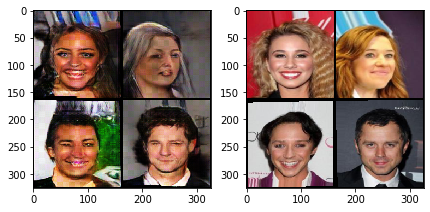

[0/1][6200/7585]	Loss_D: 0.9557	Loss_Dec: 3.5005	Aux F1: 0.9102	Loss_Enc: 2195.8184	D(x): 0.5123	D(G(z)): 0.4354
[0/1][6400/7585]	Loss_D: 0.9557	Loss_Dec: 3.4974	Aux F1: 0.9102	Loss_Enc: 2197.6696	D(x): 0.6236	D(G(z)): 0.2199
[0/1][6600/7585]	Loss_D: 0.9525	Loss_Dec: 3.5002	Aux F1: 0.9102	Loss_Enc: 2203.4229	D(x): 0.5048	D(G(z)): 0.3128
[0/1][6800/7585]	Loss_D: 0.9530	Loss_Dec: 3.4989	Aux F1: 0.9103	Loss_Enc: 2206.5557	D(x): 0.5150	D(G(z)): 0.3660
[0/1][7000/7585]	Loss_D: 0.9542	Loss_Dec: 3.4989	Aux F1: 0.9103	Loss_Enc: 2209.9561	D(x): 0.6031	D(G(z)): 0.2562
[0/1][7200/7585]	Loss_D: 0.9556	Loss_Dec: 3.4974	Aux F1: 0.9103	Loss_Enc: 2211.1316	D(x): 0.5134	D(G(z)): 0.2492
[0/1][7400/7585]	Loss_D: 0.9559	Loss_Dec: 3.4941	Aux F1: 0.9103	Loss_Enc: 2211.2937	D(x): 0.6460	D(G(z)): 0.2728


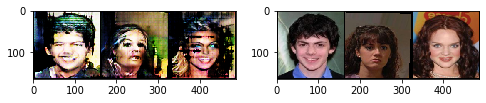

Copying file://./vaegan_dn201_2.pt [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

/
Operation completed over 1 objects/195.7 MiB.                                    
Copying file://./vaegan_dn201_opt_disc_2.pt [Content-Type=application/octet-stream]...
\
Operation completed over 1 objects/69.4 MiB.                             

In [0]:
train(net, n_epochs=1, train_loader=train_loader)

In [17]:
!nvidia-smi

Sat Nov  9 10:53:45 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.50       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P0    42W / 250W |  12261MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

[0/1][0/7585]	Loss_D: 0.7645	Loss_Dec: 3.7479	Aux F1: 0.9125	Loss_Enc: 2133.5898	D(x): 0.6156	D(G(z)): 0.2100
[0/1][200/7585]	Loss_D: 0.8734	Loss_Dec: 3.6641	Aux F1: 0.9070	Loss_Enc: 2260.8346	D(x): 0.5406	D(G(z)): 0.3822
[0/1][400/7585]	Loss_D: 0.8928	Loss_Dec: 3.7068	Aux F1: 0.9070	Loss_Enc: 2282.8573	D(x): 0.4853	D(G(z)): 0.3918
[0/1][600/7585]	Loss_D: 0.9022	Loss_Dec: 3.6820	Aux F1: 0.9067	Loss_Enc: 2328.2161	D(x): 0.5466	D(G(z)): 0.2344
[0/1][800/7585]	Loss_D: 0.9287	Loss_Dec: 3.6108	Aux F1: 0.9068	Loss_Enc: 2336.6084	D(x): 0.5553	D(G(z)): 0.2728
[0/1][1000/7585]	Loss_D: 0.9370	Loss_Dec: 3.5893	Aux F1: 0.9068	Loss_Enc: 2344.1438	D(x): 0.5369	D(G(z)): 0.3231
[0/1][1200/7585]	Loss_D: 0.9322	Loss_Dec: 3.5791	Aux F1: 0.9068	Loss_Enc: 2356.1140	D(x): 0.6835	D(G(z)): 0.2094
[0/1][1400/7585]	Loss_D: 0.9270	Loss_Dec: 3.5900	Aux F1: 0.9066	Loss_Enc: 2356.1103	D(x): 0.5042	D(G(z)): 0.2864
[0/1][1600/7585]	Loss_D: 0.9254	Loss_Dec: 3.5849	Aux F1: 0.9066	Loss_Enc: 2375.6824	D(x): 0.4824	D(G(z)

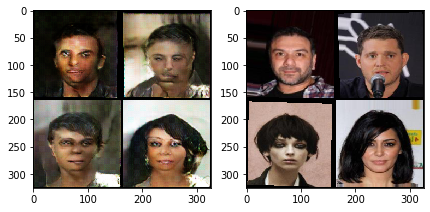

[0/1][2200/7585]	Loss_D: 0.9270	Loss_Dec: 3.5728	Aux F1: 0.9067	Loss_Enc: 2400.8723	D(x): 0.6435	D(G(z)): 0.2407
[0/1][2400/7585]	Loss_D: 0.9285	Loss_Dec: 3.5580	Aux F1: 0.9067	Loss_Enc: 2392.8437	D(x): 0.6001	D(G(z)): 0.2667
[0/1][2600/7585]	Loss_D: 0.9276	Loss_Dec: 3.5526	Aux F1: 0.9066	Loss_Enc: 2391.2120	D(x): 0.6236	D(G(z)): 0.2295
[0/1][2800/7585]	Loss_D: 0.9242	Loss_Dec: 3.5547	Aux F1: 0.9066	Loss_Enc: 2398.4207	D(x): 0.6134	D(G(z)): 0.2513
[0/1][3000/7585]	Loss_D: 0.9291	Loss_Dec: 3.5453	Aux F1: 0.9066	Loss_Enc: 2398.5268	D(x): 0.5427	D(G(z)): 0.2135
[0/1][3200/7585]	Loss_D: 0.9292	Loss_Dec: 3.5394	Aux F1: 0.9067	Loss_Enc: 2402.1755	D(x): 0.6630	D(G(z)): 0.2062
[0/1][3400/7585]	Loss_D: 0.9304	Loss_Dec: 3.5368	Aux F1: 0.9066	Loss_Enc: 2398.9510	D(x): 0.5695	D(G(z)): 0.2777
[0/1][3600/7585]	Loss_D: 0.9280	Loss_Dec: 3.5414	Aux F1: 0.9067	Loss_Enc: 2399.6454	D(x): 0.5676	D(G(z)): 0.3232
[0/1][3800/7585]	Loss_D: 0.9304	Loss_Dec: 3.5369	Aux F1: 0.9066	Loss_Enc: 2399.2299	D(x): 0.5330

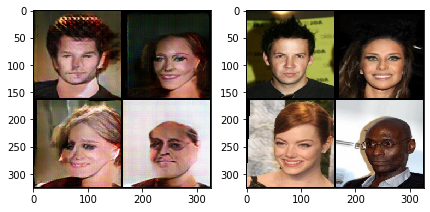

[0/1][4200/7585]	Loss_D: 0.9323	Loss_Dec: 3.5373	Aux F1: 0.9066	Loss_Enc: 2398.3009	D(x): 0.6052	D(G(z)): 0.2469
[0/1][4400/7585]	Loss_D: 0.9316	Loss_Dec: 3.5353	Aux F1: 0.9066	Loss_Enc: 2397.5877	D(x): 0.5826	D(G(z)): 0.2497
[0/1][4600/7585]	Loss_D: 0.9287	Loss_Dec: 3.5406	Aux F1: 0.9065	Loss_Enc: 2399.7520	D(x): 0.5453	D(G(z)): 0.3658
[0/1][4800/7585]	Loss_D: 0.9284	Loss_Dec: 3.5429	Aux F1: 0.9065	Loss_Enc: 2400.9281	D(x): 0.6806	D(G(z)): 0.1910
[0/1][5000/7585]	Loss_D: 0.9308	Loss_Dec: 3.5358	Aux F1: 0.9065	Loss_Enc: 2403.8638	D(x): 0.6050	D(G(z)): 0.2838
[0/1][5200/7585]	Loss_D: 0.9300	Loss_Dec: 3.5340	Aux F1: 0.9064	Loss_Enc: 2405.4266	D(x): 0.5049	D(G(z)): 0.2600
[0/1][5400/7585]	Loss_D: 0.9310	Loss_Dec: 3.5316	Aux F1: 0.9064	Loss_Enc: 2405.7414	D(x): 0.4788	D(G(z)): 0.3866
[0/1][5600/7585]	Loss_D: 0.9339	Loss_Dec: 3.5243	Aux F1: 0.9064	Loss_Enc: 2403.5432	D(x): 0.5055	D(G(z)): 0.4206
[0/1][5800/7585]	Loss_D: 0.9319	Loss_Dec: 3.5278	Aux F1: 0.9064	Loss_Enc: 2405.7700	D(x): 0.6374

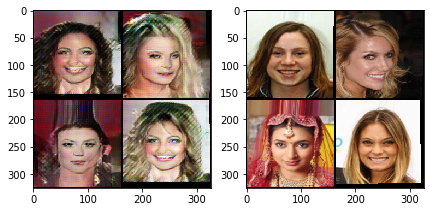

[0/1][6200/7585]	Loss_D: 0.9330	Loss_Dec: 3.5246	Aux F1: 0.9064	Loss_Enc: 2407.3429	D(x): 0.7042	D(G(z)): 0.1393
[0/1][6400/7585]	Loss_D: 0.9313	Loss_Dec: 3.5287	Aux F1: 0.9064	Loss_Enc: 2412.2097	D(x): 0.5118	D(G(z)): 0.3472
[0/1][6600/7585]	Loss_D: 0.9320	Loss_Dec: 3.5272	Aux F1: 0.9064	Loss_Enc: 2418.1700	D(x): 0.5007	D(G(z)): 0.3089
[0/1][6800/7585]	Loss_D: 0.9307	Loss_Dec: 3.5301	Aux F1: 0.9064	Loss_Enc: 2424.9016	D(x): 0.6056	D(G(z)): 0.3317
[0/1][7000/7585]	Loss_D: 0.9307	Loss_Dec: 3.5315	Aux F1: 0.9064	Loss_Enc: 2427.4306	D(x): 0.5073	D(G(z)): 0.2347
[0/1][7200/7585]	Loss_D: 0.9309	Loss_Dec: 3.5322	Aux F1: 0.9063	Loss_Enc: 2430.2092	D(x): 0.6895	D(G(z)): 0.1957
[0/1][7400/7585]	Loss_D: 0.9297	Loss_Dec: 3.5345	Aux F1: 0.9063	Loss_Enc: 2431.7605	D(x): 0.5712	D(G(z)): 0.1675


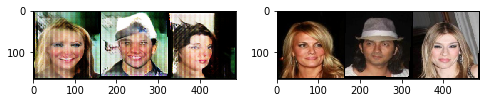

Copying file://./vaegan_dn201_2.pt [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

-
Operation completed over 1 objects/195.7 MiB.                                    
Copying file://./vaegan_dn201_opt_disc_2.pt [Content-Type=application/octet-stream]...
|
Operation completed over 1 objects/69.4 MiB.                             

In [18]:
train(net, n_epochs=1, train_loader=train_loader)

[0/1][0/7585]	Loss_D: 0.9470	Loss_Dec: 3.9103	Aux F1: 0.8943	Loss_Enc: 2509.3130	D(x): 0.5465	D(G(z)): 0.2054
[0/1][200/7585]	Loss_D: 0.9050	Loss_Dec: 3.5903	Aux F1: 0.9068	Loss_Enc: 2422.2801	D(x): 0.6199	D(G(z)): 0.2070
[0/1][400/7585]	Loss_D: 0.9136	Loss_Dec: 3.5250	Aux F1: 0.9073	Loss_Enc: 2367.2968	D(x): 0.5651	D(G(z)): 0.2144
[0/1][600/7585]	Loss_D: 0.9265	Loss_Dec: 3.4673	Aux F1: 0.9078	Loss_Enc: 2364.7816	D(x): 0.5654	D(G(z)): 0.2591
[0/1][800/7585]	Loss_D: 0.9320	Loss_Dec: 3.4598	Aux F1: 0.9079	Loss_Enc: 2343.1278	D(x): 0.6214	D(G(z)): 0.2118
[0/1][1000/7585]	Loss_D: 0.9308	Loss_Dec: 3.4571	Aux F1: 0.9079	Loss_Enc: 2324.3883	D(x): 0.4946	D(G(z)): 0.3213
[0/1][1200/7585]	Loss_D: 0.9331	Loss_Dec: 3.4684	Aux F1: 0.9080	Loss_Enc: 2330.7767	D(x): 0.5013	D(G(z)): 0.2874
[0/1][1400/7585]	Loss_D: 0.9346	Loss_Dec: 3.4805	Aux F1: 0.9079	Loss_Enc: 2331.1106	D(x): 0.5518	D(G(z)): 0.2442
[0/1][1600/7585]	Loss_D: 0.9475	Loss_Dec: 3.4811	Aux F1: 0.9081	Loss_Enc: 2327.1048	D(x): 0.5148	D(G(z)

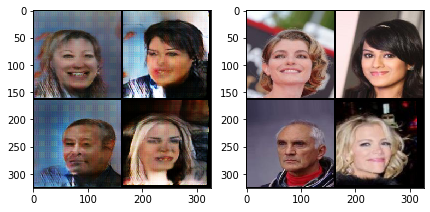

[0/1][2200/7585]	Loss_D: 0.9497	Loss_Dec: 3.4568	Aux F1: 0.9082	Loss_Enc: 2309.0517	D(x): 0.5542	D(G(z)): 0.2219
[0/1][2400/7585]	Loss_D: 0.9549	Loss_Dec: 3.4492	Aux F1: 0.9082	Loss_Enc: 2308.1200	D(x): 0.5032	D(G(z)): 0.2320
[0/1][2600/7585]	Loss_D: 0.9599	Loss_Dec: 3.4312	Aux F1: 0.9082	Loss_Enc: 2303.1204	D(x): 0.5520	D(G(z)): 0.3227
[0/1][2800/7585]	Loss_D: 0.9597	Loss_Dec: 3.4272	Aux F1: 0.9082	Loss_Enc: 2302.5305	D(x): 0.5831	D(G(z)): 0.2826
[0/1][3000/7585]	Loss_D: 0.9563	Loss_Dec: 3.4291	Aux F1: 0.9083	Loss_Enc: 2308.1330	D(x): 0.5401	D(G(z)): 0.3148
[0/1][3200/7585]	Loss_D: 0.9544	Loss_Dec: 3.4373	Aux F1: 0.9082	Loss_Enc: 2312.7523	D(x): 0.6147	D(G(z)): 0.2800
[0/1][3400/7585]	Loss_D: 0.9539	Loss_Dec: 3.4377	Aux F1: 0.9082	Loss_Enc: 2321.7098	D(x): 0.4835	D(G(z)): 0.2738
[0/1][3600/7585]	Loss_D: 0.9495	Loss_Dec: 3.4496	Aux F1: 0.9082	Loss_Enc: 2329.2042	D(x): 0.6032	D(G(z)): 0.2077
[0/1][3800/7585]	Loss_D: 0.9491	Loss_Dec: 3.4522	Aux F1: 0.9083	Loss_Enc: 2336.4953	D(x): 0.5768

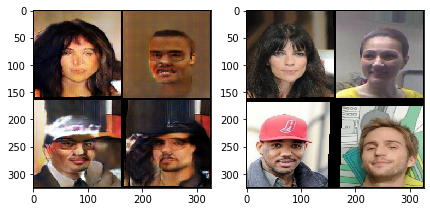

[0/1][4200/7585]	Loss_D: 0.9472	Loss_Dec: 3.4598	Aux F1: 0.9082	Loss_Enc: 2347.3613	D(x): 0.5691	D(G(z)): 0.2275
[0/1][4400/7585]	Loss_D: 0.9470	Loss_Dec: 3.4619	Aux F1: 0.9082	Loss_Enc: 2348.9978	D(x): 0.5104	D(G(z)): 0.3059
[0/1][4600/7585]	Loss_D: 0.9466	Loss_Dec: 3.4686	Aux F1: 0.9083	Loss_Enc: 2352.0633	D(x): 0.5763	D(G(z)): 0.1886


In [0]:
train(net, n_epochs=1, train_loader=train_loader)

In [0]:
# for j, (data_batch,target_batch) in enumerate(test_loader):
#     data_batch = data_batch.cuda()
    
#     out, out_labels, out_layer, mus, variances = net(data_batch)
    
#     fig, ax = plt.subplots(1, 2, figsize=(8,8)) 
#     out = (out * 0.5) + 0.5
#     ax[0].imshow(np.transpose(vutils.make_grid(out.detach().cpu()[:16], nrow=4, padding=2, normalize=True),(1,2,0)))
#     ax[1].imshow(np.transpose(vutils.make_grid(data_batch.detach().cpu()[:16], nrow=4, padding=2, normalize=True),(1,2,0)))
#     plt.show()   
#     break